In [1]:
#NAMING RULES
# rootname is birdID_recorder_hour_month#-day#-year eg: frye1_A_0_06-12-2023
# sonic visualizer files are named as sonic_root eg: sonic_frye1_B_0_jun12-2023
# exported sonic visualiser files are named as clap_root eg: clap_frye1_B_0_jun12-2023
# raven tables are named as raven_root eg: raven_frye1_B_0_jun12-2023
# wave names are recorder_date_time eg: HERMIT1_20230612_050337
# spectrograms are spectrogram_wavename eg: spectrogram_HERMIT1_20230612_050337
# pickle dataframes are pickle_df_root
# csv dataframes are csv_df_root

In [1]:
import librosa
import librosa.display
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.animation import FuncAnimation
from IPython import display
import random 
import scipy.stats as ss
# import amp_functions as af
import h5py
from datetime import datetime
from datetime import timedelta
import math
import glob
import copy
import pickle
import pandas as pd


In [2]:
#all functions

def fourier(wave):
    D = librosa.stft(wave)
    D = D[120:743,:]
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

def fourier_for_time(filename, wave_start = 0, wave_end = 0, win_len = 2048):
    y, sr = librosa.load(filename)
    start_int = int(wave_start * sr)
    end_int = int(wave_end * sr)
    duration = librosa.get_duration(y=y, sr=sr)
    if wave_start > duration:
        return 'fail'
    
    if end_int > 0 and wave_end < duration:
        D = librosa.stft(y[start_int:end_int], win_length = win_len)
    else:
        D = librosa.stft(y[start_int:], win_length = win_len)
    D = D[120:743,:]
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

def create_spec_files(wave_name_list):
    spec_list = []
    for name in wave_name_list:
        y, sr = librosa.load(name)
        spect = (fourier(y))
    
    #creating spec_list file for later loading.
        with h5py.File('spectrogram_' + name.split('.')[0] + '.h5', 'w') as hf:
            hf.create_dataset('spectrogram_' + name.split('.')[0], data=spect)

def get_time_gaps(timestamps):
    time_gaps = []
    for i in range(len(timestamps) - 1):
        time_gaps.append(timestamps[i+1] - timestamps[i])
    plt.scatter(range(len(timestamps[:-1])), time_gaps)
    plt.plot(range(len(timestamps[:-1])), time_gaps)
    plt.show()
    return time_gaps

#LOCATION FUNCTIONS

#takes in timestamps, drift slopes, and the recorder differences, and synchronizes everything
def adjust_for_drift(timestamps, slopes, rec_diffs):
    new_times = []
    for i in range(len(timestamps)):
        temp_list = []
        for j in range(len(timestamps[i])):
            adj_time = timestamps[i][j] - rec_diffs[i]
            new_time = adj_time - slopes[i]*(timestamps[0][j] - timestamps[0][0])
            temp_list.append(new_time)
        new_times.append(temp_list)
    return new_times

def calculate_drift_slopes(timestamp_arrays):
    slope_list = []
    x_diff = timestamp_arrays[0][-1] - timestamp_arrays[0][0]
    for array in timestamp_arrays:
        start_diff = array[0] - timestamp_arrays[0][0]
        end_diff = array[-1] - timestamp_arrays[0][-1]
        y_diff = end_diff - start_diff
        slope_list.append(y_diff/x_diff)
    return slope_list

def spect_snip(spect, start, duration=2):
    spect_time_converter = 0.023219814
    start_sample = int(np.floor(start / spect_time_converter))
    end_sample = int(np.floor((start + duration) / spect_time_converter))
    return spect[:, start_sample:end_sample]

def sig_to_noise(spec):
    flat_spec = spec.flatten()
    sorted_spec = np.sort(flat_spec)
    top_mean = np.mean(sorted_spec[-20:])
    median = np.median(sorted_spec)
    return top_mean - median

def display_spect(array, title = 'sample'):
    fig, ax = plt.subplots(figsize=(15, 7))
    # img = librosa.display.specshow(array[1], x_axis='time', y_axis=None, sr=22050, ax=ax)
    img = librosa.display.specshow(array, x_axis='time', y_axis=None, sr=22050, ax=ax)
    ax.set_title(str(title), fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    fig.gca().set_yticks(range(0, 743-120, 25))
    fig.gca().set_ylabel("Row")
    plt.show()
    
def zero_in_on_location(recorder_locations, lags_by_song, valleys_by_song, xLength, yLength, zLength, ref_rec):
    start = datetime.now()
    best_points = []
    all_one_percenters = []
    best_scores = []
    best_errors = []
    for song_index, song in enumerate(lags_by_song):
        print(f"song {song_index}: ", song)

        if check_how_many_nan(song) < 8:
            center = [0, 0, 0]
            for i in range(5):
                all_points, distance_list = get_point_distance_lists(recorder_locations, center, xLength*(.5**i), yLength*(.5**i), zLength*(.5**i), ref_rec)
                #print(valleys_by_song[song_index])
                score_list = score_all_points_for_one_song(distance_list, song, valleys_by_song[song_index])
                #print(score_list)
                one_percenter_list, best_score, best_point, error_score = return_bests_for_a_song(all_points, score_list, 2)
                # print('round ', i+1, ':', best_point)
                #print(best_score, best_point)
                center = best_point
                if i == 0:
                    first_percenters = one_percenter_list
            all_one_percenters.append(first_percenters)
            best_points.append(best_point)
            best_scores.append(best_score)
            best_errors.append(error_score)
            print('-----------------')
        else:
            print("oops! too many nans in this profile to get a location!")
            all_one_percenters.append([])
            best_points.append([np.nan])
            best_scores.append(np.nan)
            best_errors.append(np.nan)
    print(datetime.now() - start)
    print(best_points)
    return best_points, all_one_percenters, best_scores, best_errors

def get_point_distance_lists(mics, center, xLength, yLength, zLength, ref_rec):
    all_distances = []
    points = []
    for x in np.linspace((center[0]-(xLength/2)), (center[0]+(xLength/2)), 11):
        for y in np.linspace((center[1]-(yLength/2)), (center[1]+(yLength/2)), 11):
            for z in np.linspace((center[2]-(zLength/2)), (center[2]+(zLength/2)), 11):
                if z >= 0:
                    arbitrary_point = [x,y,z]
                    point_to_mic_dists = []
                    for mic in mics:
                        point_to_mic_dists.append(((mic[0] - arbitrary_point[0])**2 + (mic[1] - arbitrary_point[1])**2 + (mic[2] - arbitrary_point[2])**2)**0.5)
                    point_to_mic_dists = np.array(point_to_mic_dists)/343
                    point_to_mic_dists = point_to_mic_dists - point_to_mic_dists[ref_rec]
                    all_distances.append(point_to_mic_dists)
                    points.append([x, y, z])
    return points, all_distances

def get_dist_profiles_from_timestamps(timestamps_list):
    dist_profiles = []
    for timestamps in timestamps_list:
        dist_profile = []
        adj_timestamps = []
        #subtract the minimum time
        for stamp in timestamps:
            adj_timestamps.append(stamp - np.min(timestamps))
        #convert time to distance
        for adj_stamp in adj_timestamps:
            dist_profile.append(adj_stamp * 343)
        dist_profiles.append(dist_profile)
    return dist_profiles

def get_dist_profile(mics, point):
    distances = []
    for mic in mics:
        distances.append(((mic[0] - point[0])**2 + (mic[1] - point[1])**2 + (mic[2] - point[2])**2)**0.5)
    adj_distances = []
    for distance in distances:
        adj_distances.append(distance - np.min(distances))
    return adj_distances

def score_all_points_for_one_song(transformed_dists, song_profile, valleys):
    song_score_list = []
    for dist_profile in transformed_dists:
        best_score, error_score = score_a_valley_point(dist_profile, song_profile, valleys)
        song_score_list.append([best_score, error_score])
    return song_score_list

def return_bests_for_a_song(point_list, score_list, percentile):
    one_percenter_list = []
    percent_score = np.percentile(score_list, percentile)
    one_percenters = []
    best_score = 100000000
    best_point = []
    error_score = 10000000000
    for i in range(len(score_list)):
        if score_list[i][0] < best_score:
            best_score = score_list[i][0]
            best_point = point_list[i]
            error_score = score_list[i][1]
        if score_list[i][0] < percent_score:
            one_percenters.append([score_list[i][0], point_list[i]])
    one_percenter_list.append(one_percenters)
    return one_percenter_list, best_score, best_point, error_score

def score_a_point(dists, lags):
    best_score = 1000
    for i in np.linspace(-.1, .1, 21):
        adj_lags = lags + i
        score = 0
        for i in range(len(dists)):
            score += abs(dists[i] - adj_lags[i])
        if score < best_score:
            best_score = score
    return best_score

def score_a_squashed_point(dists, lags):
    dists = dists * (1/(20*dists + 1))
    lags = lags * (1/(20*lags + 1))
    best_score = 1000
    for shift in np.linspace(-.1, .1, 21):
        adj_lags = lags + shift
        score = 0
        for i in range(len(dists)):
            if not math.isnan(dists[i]) and not math.isnan(adj_lags[i]):
                score += abs(dists[i] - adj_lags[i])
        if score < best_score:
            best_score = score
    return best_score

def score_a_valley_point(dists, lags, valleys):
    best_score = 10000000
    best_error_score = 1000000
    score = 0
    error_list = []
    for i in range(len(dists)):
        if not math.isnan(dists[i]) and not math.isnan(lags[i]):
            score += (abs(dists[i] - lags[i])) * (valleys[i])**2
            error_list.append(abs(dists[i] - lags[i]))
    if score < best_score:
        best_score = score
        best_error_score = np.mean(error_list)
    return best_score, best_error_score

def score_all_points_for_song_list(transformed_dists, log_amps):
    total_score_list = []
    for song_profile in log_amps:
        song_score_list = []
        for dist_profile in transformed_dists:
            song_score_list.append(score_a_point(dist_profile, song_profile))
        total_score_list.append(song_score_list)
    return total_score_list


def get_max_lag(recorder_locations, mic_num):
    max_dist = 0
    for i in range(len(recorder_locations)):
        if i == mic_num:
            continue
        dist = ((recorder_locations[mic_num][0] - recorder_locations[i][0])**2 + (recorder_locations[mic_num][1] - recorder_locations[i][1])**2)**0.5
        if dist > max_dist:
            max_dist = dist
    return max_dist/343

def swap_faint_lags(recorder_locations, timestamps, durations, dur_max):
    for song_index in range(len(timestamps)):
        for mic_index in range(len(timestamps[song_index])):
            if durations[song_index][mic_index] > dur_max:
                timestamps[song_index][mic_index] = get_max_lag(recorder_locations, mic_index)
    return timestamps

def make_mean_points(lags_by_song, cluster):
    mean_points = []
    for i in range(len(lags_by_song)):
        if i <= len(lags_by_song) - cluster:
            mean_points.append(np.nanmean(lags_by_song[i:i+cluster], axis=0))
        else:
            mean_points.append(np.nanmean(lags_by_song[i-cluster:], axis=0))
    return np.array(mean_points)


#PLOTS
#####################
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def show_bird_2d_plot(recorder_locations, bird_points, x_border, y_border, title, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(bird_points)):
        xs.append(bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(bird_points[i][2])
        cs.append(i)

    points = ax.scatter(xs, ys, c=cs, s=50, cmap="plasma")
    for i in range(len(bird_points)):
        ax.annotate(i, (xs[i]+.5, ys[i]+.5))


    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green')
        
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(-y_border,y_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()

def shave_off_nulls(song_array, threshold):
    new_array = []
    for song in song_array:
        nancount = 0
        for ts in song:
            if math.isnan(ts):
                nancount +=1
        if nancount < threshold:
            new_array.append(song)
    return np.array(new_array)

def show_two_birds_2d_plot(recorder_locations, alpha_corrected_by_song, beta_corrected_by_song, alpha_bird_points, beta_bird_points, x_border, y_border, start_time = 0, end_time = 100000, jitter_max=0, annotate=True, sparse = False):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)
    
    alpha_start_i = 0
    for i in range(len(alpha_corrected_by_song)):
        if alpha_corrected_by_song[i] > start_time:
            alpha_start_i = i
            break
    alpha_end_i = 0
    for i in range(len(alpha_corrected_by_song)):
        if alpha_corrected_by_song[i] > end_time:
            break
        alpha_end_i = i
        
    beta_start_i = 0
    for i in range(len(beta_corrected_by_song)):
        if beta_corrected_by_song[i] > start_time:
            beta_start_i = i
            break
    beta_end_i = 0
    for i in range(len(beta_corrected_by_song)):
        if beta_corrected_by_song[i] > end_time:
            break
        beta_end_i = i

            
    alpha_bird_points = alpha_bird_points[alpha_start_i: alpha_end_i]
    beta_bird_points = beta_bird_points[beta_start_i: beta_end_i]
    alpha_corrected_by_song = alpha_corrected_by_song[alpha_start_i: alpha_end_i]
    beta_corrected_by_song = beta_corrected_by_song[beta_start_i: beta_end_i]
    
    
    print(alpha_start_i, alpha_end_i, beta_start_i, beta_end_i)        
    first_song = np.min([np.nanmin(alpha_corrected_by_song[0]), np.nanmin(beta_corrected_by_song[0])])
    last_song = np.max([np.nanmax(alpha_corrected_by_song[-1]), np.nanmax(beta_corrected_by_song[-1])])
    # print(first_song, last_song)
    singing_duration = int(last_song-first_song+1)
    
    adjusted_alpha_song_timings = []
    alpha_song_timings = []
    for song in alpha_corrected_by_song:
        alpha_song_timings.append(int(np.nanmin(song)))
        adjusted_alpha_song_timings.append(int(np.nanmin(song) - first_song))
    
    adjusted_beta_song_timings = []
    beta_song_timings = []
    for song in beta_corrected_by_song:
        beta_song_timings.append(int(np.nanmin(song)))
        adjusted_beta_song_timings.append(int(np.nanmin(song) - first_song))
    
    

    color1 = "#D4CC47"
    color2 = "#7002bf"
    num_points = singing_duration
    
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green', alpha=.2)
        
    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(alpha_bird_points)):
        xs.append(alpha_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(alpha_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(alpha_bird_points[i][2])
        cs.append(get_color_gradient(color1, color2, num_points)[adjusted_alpha_song_timings[i]])

    alpha_points = ax.scatter(xs, ys, c=cs, s=20)
    if annotate:
        last_annotation = 0
        for i in range(len(alpha_bird_points)):
            if sparse:
                if alpha_song_timings[i] > last_annotation + 60:
                    ax.annotate(f"{alpha_song_timings[i]}", (xs[i]+1, ys[i]+1))
                    last_annotation = alpha_song_timings[i]
            else:
                ax.annotate(f"{alpha_song_timings[i]}", (xs[i]+1, ys[i]+1))


    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(beta_bird_points)):
        xs.append(beta_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(beta_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(beta_bird_points[i][2])
        cs.append(get_color_gradient(color1, color2, num_points)[adjusted_beta_song_timings[i]])

    beta_points = ax.scatter(xs, ys, c=cs, s=50, marker='+')
    if annotate:
        last_annotation = 0
        for i in range(len(beta_bird_points)):
            if sparse:
                if beta_song_timings[i] > last_annotation + 60:
                    ax.annotate(f"{beta_song_timings[i]}", (xs[i]+1, ys[i]+1))
                    last_annotation = beta_song_timings[i]
            else:
                ax.annotate(f"{beta_song_timings[i]}", (xs[i]+1, ys[i]+1))


        
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(-y_border,y_border)

    if start_time == 0:
        start_string = 'beginning'
    else:
        start_string = f'{start_time}'
    if end_time == 100000:
        end_string = 'end'
    else:
        end_string = f'{end_time}'

    
    plt.title(f'Points from {start_string} to {end_string}')
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()
    
    return alpha_start_i, alpha_end_i, beta_start_i, beta_end_i

def create_animation(mics, graph_size, alpha_points, beta_points, alpha_timings, beta_timings, total_length, filename=""):
    fig = plt.figure(figsize=(13,10))



    # lines = plt.plot([], "o")
    # line = lines[0]
    # lines2 = plt.plot([], "o")
    # line2 = lines2[0]

    alpha_x = alpha_points[:,0]
    alpha_y = alpha_points[:,1]
    beta_x = beta_points[:,0]
    beta_y = beta_points[:,1]

    plt.title("HETH Interaction June 12: 5:30am")
    # plt.axis("scaled")
    plt.xlim(-graph_size, graph_size)
    plt.ylim(-graph_size, graph_size)

    for i in range(len(recorder_locations)):
        plt.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green', alpha=.2)
    
    alpha_color1 = "#0e29a1"
    alpha_color2 = "#ffffff"
    beta_color1 = "#d68904"
    beta_color2 = "#ffffff"
    ping_length = 50
    num_points = ping_length


    
    def create_list_of(listy, value):
        new_list = []
        for i in listy:
            new_list.append(value)
        return new_list


    alpha_ping_opacities = create_list_of(alpha_timings, 0)
    beta_ping_opacities = create_list_of(beta_timings, 0)
    alpha_static_opacities = create_list_of(alpha_timings, 0)
    beta_static_opacities = create_list_of(beta_timings, 0)

    alpha_gradient = get_color_gradient(alpha_color1, alpha_color2, num_points)
    beta_gradient = get_color_gradient(beta_color1, beta_color2, num_points)
    alpha_sizes = create_list_of(alpha_timings, 50)
    beta_sizes = create_list_of(beta_timings, 50)
    alpha_colors = create_list_of(alpha_timings, alpha_color1)
    beta_colors = create_list_of(beta_timings, beta_color1)

    alpha_ping_dot = plt.scatter(alpha_x, alpha_y, s=alpha_sizes, c = alpha_colors)
    alpha_main_dot = plt.scatter(alpha_x, alpha_y, s=alpha_sizes, c=alpha_colors, alpha=alpha_static_opacities)

    beta_ping_dot = plt.scatter(beta_x, beta_y, s=beta_sizes, c = beta_colors)
    beta_main_dot = plt.scatter(beta_x, beta_y, s=50, c=beta_colors, alpha=beta_static_opacities)

    frame_int = 50
    alpha_secs = alpha_timings
    alpha_frames = (np.rint(alpha_secs * 1000/ frame_int)).astype(int)
    beta_secs = beta_timings
    beta_frames = (np.rint(beta_secs * 1000/ frame_int)).astype(int)
    print(alpha_frames)
    print(beta_frames)

    def animate(frame):
        #dot.set_offsets((frame%10, frame%20))
        for i in range(len(alpha_frames)):
            if frame > alpha_frames[i]:
                alpha_static_opacities[i] = .4
            else:
                alpha_static_opacities[i] = 0
        
        for i in range(len(alpha_frames)):
            #changing the size of the pinging dot
            if frame > alpha_frames[i] and frame < alpha_frames[i] + ping_length:
                adjuster = (frame - alpha_frames[i]%ping_length) %ping_length
                new_size = 50 + 400*adjuster
                alpha_sizes[i] = new_size
                alpha_ping_opacities[i] = 1-(adjuster/ping_length)
            else:
                alpha_sizes[i] = 50
                alpha_ping_opacities[i] = 0

        alpha_ping_dot.set_sizes(alpha_sizes)
        #alpha_ping_dot.set_facecolor(alpha_colors)
        alpha_ping_dot.set_alpha(alpha_ping_opacities)
        alpha_main_dot.set_alpha(alpha_static_opacities)
        
        for i in range(len(beta_frames)):
            if frame > beta_frames[i]:
                beta_static_opacities[i] = .4
            else:
                beta_static_opacities[i] = 0
        
        for i in range(len(beta_frames)):
            if frame > beta_frames[i] and frame < beta_frames[i] + ping_length:
                adjuster = (frame - beta_frames[i]%ping_length) %ping_length
                new_size = 50 + 400*adjuster
                beta_sizes[i] = new_size
                #beta_colors[i] = beta_gradient[(frame - beta_frames[i] % ping_length) % ping_length]
                beta_ping_opacities[i] = 1-(adjuster/ping_length)
            else:
                beta_sizes[i] = 50
                beta_ping_opacities[i] = 0

        
        beta_ping_dot.set_sizes(beta_sizes)
        #beta_ping_dot.set_facecolor(beta_colors)
        beta_ping_dot.set_alpha(beta_ping_opacities)
        beta_main_dot.set_alpha(beta_static_opacities)
        # x = listx[int(frame/100)]
        # y = listy[int(frame/100)]
        # v = frame/5 - 20
        # w = -frame/20 - 10
        # line.set_data((x, y))
        # line2.set_data((v, w))

            
        
    anim = FuncAnimation(fig, animate, frames=int(total_length*1000*(1/frame_int)), interval=frame_int)

    video = anim.to_html5_video()
    if filename == "":
        pass
    else:
        anim.save(filename + ".mp4")
    html = display.HTML(video)
    display.display(html)
    plt.close()
    
def show_two_grouped_birds_2d_plot(recorder_locations, alpha_groupings, beta_groupings, alpha_corrected_by_song, beta_corrected_by_song, alpha_bird_points, beta_bird_points, x_border, y_border, title, jitter_max=0, annotate=True):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)
    
    first_song = np.min([np.nanmin(alpha_corrected_by_song[0]), np.nanmin(beta_corrected_by_song[0])])
    last_song = np.max([np.nanmax(alpha_corrected_by_song[-1]), np.nanmax(beta_corrected_by_song[-1])])
    # print(first_song, last_song)
    singing_duration = int(last_song-first_song+1)
    
    alpha_song_timings = []
    for song in alpha_corrected_by_song:
        alpha_song_timings.append(int(np.nanmin(song) - first_song))
    
    beta_song_timings = []
    for song in beta_corrected_by_song:
        beta_song_timings.append(int(np.nanmin(song) - first_song))
    

    color1 = "#D4CC47"
    color2 = "#7002bf"
    num_points = singing_duration
    
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green', alpha=.2)
        
    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(alpha_bird_points)):
        xs.append(alpha_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(alpha_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(alpha_bird_points[i][2])
        cs.append(get_color_gradient(color1, color2, num_points)[alpha_song_timings[i]])

    alpha_points = ax.scatter(xs, ys, c=cs, s=20, cmap="plasma")
    if annotate:
        for i in range(len(alpha_bird_points)):
            for group in alpha_groupings:
                if i == group[0]:
                    if group[1] - group[0] > 1:
                        ax.annotate(f"{alpha_song_timings[group[0]]}, {alpha_song_timings[group[1]]}", (xs[i]+1, ys[i]+1))
                    else:
                        ax.annotate(f"{alpha_song_timings[group[0]]}", (xs[i]+1, ys[i]+1))

    print(alpha_song_timings[-1])
    print(beta_song_timings[-1])
    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(beta_bird_points)):
        xs.append(beta_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(beta_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(beta_bird_points[i][2])
        cs.append(get_color_gradient(color1, color2, num_points)[beta_song_timings[i]])

    beta_points = ax.scatter(xs, ys, c=cs, s=50, marker='+', cmap="plasma")
    if annotate:
        for i in range(len(beta_bird_points)):
            ax.annotate(f"{beta_song_timings[i]}", (xs[i]+1, ys[i]+1))
        

        
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(-y_border,y_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()     

def animate_two_birds_2d_plot(recorder_locations, alpha_corrected_by_song, beta_corrected_by_song, alpha_bird_points, beta_bird_points, x_border, y_border, title, jitter_max=0):

    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 150  
    plt.ioff()
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)





   
    
    first_song = np.min([np.nanmin(alpha_corrected_by_song[0]), np.nanmin(beta_corrected_by_song[0])])
    last_song = np.max([np.nanmax(alpha_corrected_by_song[-1]), np.nanmax(beta_corrected_by_song[-1])])
    print(first_song, last_song)
    singing_duration = int(last_song-first_song+1)
    
    alpha_song_timings = []
    for song in alpha_corrected_by_song:
        alpha_song_timings.append(int(np.nanmin(song) - first_song))
    
    beta_song_timings = []
    for song in beta_corrected_by_song:
        beta_song_timings.append(int(np.nanmin(song) - first_song))
    

    color1 = "#D4CC47"
    color2 = "#a70bd9"
    num_points = singing_duration
    
    for i in range(len(recorder_locations)):
        plt.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green')
        
    alpha_xs = []
    alpha_ys = []
    alpha_zs = []
    alpha_cs = []

    for i in range(len(alpha_bird_points)):
        alpha_xs.append(alpha_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        alpha_ys.append(alpha_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        alpha_zs.append(alpha_bird_points[i][2])
        alpha_cs.append(get_color_gradient(color1, color2, num_points)[alpha_song_timings[i]])

    beta_xs = []
    beta_ys = []
    beta_zs = []
    beta_cs = []

    for i in range(len(beta_bird_points)):
        beta_xs.append(beta_bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        beta_ys.append(beta_bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        beta_zs.append(beta_bird_points[i][2])
        beta_cs.append(get_color_gradient(color1, color2, num_points)[beta_song_timings[i]])

    print(beta_song_timings)
    print(beta_bird_points)
    print(beta_xs)
    def animate(t):
        plt.cla()
    
        alpha_count = 0
        beta_count = 0
        for sec in range(singing_duration):
            plt.xlim(-x_border, x_border)
            plt.ylim(-y_border,y_border)
            # plt.title(title)
            # # plt.legend(loc='upper left')
            # plt.xlabel('position west to east (metres)')
            # plt.ylabel('position south to north (metres)')
            if sec in alpha_song_timings:
                plt.scatter(alpha_xs[0:alpha_count+1], alpha_ys[0:alpha_count+1], c=alpha_cs[0:alpha_count+1], s=50)
                plt.annotate(f"{alpha_song_timings[alpha_count]}", (alpha_xs[alpha_count] + 1, alpha_ys[alpha_count] + 1))
                alpha_count += 1
            if sec in beta_song_timings:
                print(sec, beta_count)
                plt.scatter(beta_xs[beta_count], beta_ys[beta_count], c=beta_cs[beta_count], s=50)
                plt.annotate(f"{beta_song_timings[beta_count]}", (beta_xs[beta_count] + 1, beta_ys[beta_count] + 1))
                beta_count += 1

    FuncAnimation(fig, animate, frames=10)

       
    
def show_2d_plot(recorder_locations, bird_points, speaker_location, x_border, y_border, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []
    zs = []
    cs = []

    for i in range(len(bird_points)):
        xs.append(bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
        ys.append(bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
        zs.append(bird_points[i][2])
        cs.append(i)

    #points = ax.scatter(xs, ys, c=cs, s=50, cmap="plasma")
    #for i in range(len(bird_points)):
        #ax.annotate(i, (xs[i]+.5, ys[i]+.5))


    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green')

    #plt.scatter(speaker_location[0], speaker_location[1], 1000, alpha=.2, c='purple', label='speaker position')
        
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(-y_border,y_border)
    
    plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()
    
def display_2_profiles(recorder_locations, best_match, actual_data, title):
    letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K']
    
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.title(str(title) + ": all points")

    mic_names = []
    for i in range(len(recorder_locations)):
        mic_names.append(f'Mic-{letter_list[i]}')
    
    
    print(best_match)
    best_match_dists = get_dist_profile(recorder_locations, best_match)
    best_match_lags = np.array(best_match_dists)/343
    
    plt.scatter(mic_names, best_match_lags, c='red')
    plt.plot(mic_names, best_match_lags, '-', c='red', label=f"best match:{best_match}")

    mean_lags = np.mean(actual_data, axis=0)
    mean_lags = mean_lags - np.min(mean_lags)
    color1 = "#D4CC47"
    color2 = "#a70bd9"
    num_points = len(actual_data)
    for i in range(len(actual_data)):
        plt.scatter(mic_names, actual_data[i], alpha=.5, color=get_color_gradient(color1, color2, num_points)[i])
        plt.plot(mic_names, actual_data[i], ':', alpha=.5, color=get_color_gradient(color1, color2, num_points)[i])

    plt.scatter(mic_names, mean_lags, color="blue")
    plt.plot(mic_names, mean_lags, color="blue", label="mean of recorded lags")    

    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    
def display_3_profiles(recorder_locations, speaker_location, best_match, actual_data):
    letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K']

    mic_names = []
    for i in range(len(recorder_locations)):
        mic_names.append(f'Mic-{letter_list[i]}')
    
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.title('Comparing speaker, best match, and data')

    speaker_dists = get_dist_profile(recorder_locations, speaker_location)
    speaker_lags = np.array(speaker_dists)/343

    plt.scatter(mic_names, speaker_lags, c='black')
    plt.plot(mic_names, speaker_lags, '-', c='black', label=f"speaker{speaker_location}")

    print(best_match)
    best_match_dists = get_dist_profile(recorder_locations, best_match)
    best_match_lags = np.array(best_match_dists)/343
    
    plt.scatter(mic_names, best_match_lags, c='red')
    plt.plot(mic_names, best_match_lags, '-', c='red', label=f"best match:{best_match}")

    mean_lags = np.mean(actual_data, axis=0)
    mean_lags = mean_lags - np.min(mean_lags)
    
    for i in range(len(actual_data)):
        plt.scatter(mic_names, actual_data[i], alpha=.25)
        plt.plot(mic_names, actual_data[i], ':', alpha=.25)

    plt.scatter(mic_names, mean_lags, color="blue")
    plt.plot(mic_names, mean_lags, color="blue", label="mean of recorded lags")    

#    plt.ylim([-.02, .1])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

    
def group_names_by_char(name_list, char, index=0):
    sorted_names = []
    for i in range(len(name_list)):
        if name_list[i] not in sum(sorted_names, []):
            temp_list = []
            temp_list.append(name_list[i])
            for j in range(len(name_list)):
                if j > i and name_list[i].split(char)[index] == name_list[j].split(char)[index]:
                    temp_list.append(name_list[j])
            sorted_names.append(temp_list)
    return sorted_names    

def find_smallest_rec(array, index):
    smallest_rec = 0
    smallest_value = array[0][index]
    for i in range(len(array)):
        if array[i][index] < smallest_value:
            smallest_rec = i
            smallest_value = array[i][index]
    return smallest_rec
    
    
def index_in_range_of_all(array, index):
    for recorder in array:
        if index >= len(recorder):
            return False
    return True
    
def index_beyond_all(array, index):
    for recorder in array:
        if len(recorder) > index:
            return False
    return True
    
def add_nans_to_array(array, array1, signal_array):
    song_i = 0
    total_possible_length = 0
    for recorder in array:
        total_possible_length += len(recorder)
    while song_i < total_possible_length:
        if index_in_range_of_all(array, song_i):
            rec_i = find_smallest_rec(array, song_i)
            for k in range(len(array)):
                if array[k][song_i] - array[rec_i][song_i] > 1:
                    array[k].insert(song_i, np.nan)
                    array1[k].insert(song_i, np.nan)
                    signal_array[k].insert(song_i, np.nan)
        elif not index_beyond_all(array, song_i):
            for k in range(len(array)):
                if len(array[k]) <= song_i:
                    array[k].append(np.nan)
                    array1[k].append(np.nan)
                    signal_array[k].append(np.nan)
        else:
            return array, array1, signal_array
        song_i += 1
    return array, array1, signal_array

def Build_Timestamp_Arrays(timestamp_names, wave_name_list):
    
    actual_timestamps_by_rec = []
    durations_by_rec = []
    for name in timestamp_names:
        my_data = genfromtxt(name, delimiter=',')
        actual_timestamps_by_rec.append(my_data[:, 0])
        durations_by_rec.append(my_data[:, 2])
        
    #check shape of each timestamp list to see that they all agree    
    for i in range(len(actual_timestamps_by_rec)):
        print("shape of #", i, " recorder array: ", np.shape(actual_timestamps_by_rec[i]))

    slope_list = calculate_drift_slopes(actual_timestamps_by_rec)
    #calculate recorder differences based on first timestamp on the recording (needs to be a distinct sound when all recorders are in the same spot)
    rec_differences = []
    for i in range(len(actual_timestamps_by_rec)):
        rec_differences.append(actual_timestamps_by_rec[i][0] - actual_timestamps_by_rec[0][0])

    
    #correct for clock drift and different start times on recorders
    list_corrected_by_rec = adjust_for_drift(actual_timestamps_by_rec, slope_list, rec_differences)

    #turn the inner numpy arrays to lists so the whole thing can be changed all into numpy arrays
    list_actual_timestamps_by_rec = []
    for array in actual_timestamps_by_rec:
        list_actual_timestamps_by_rec.append(array.tolist())

    #transpose them into numpy arrays that are organized by song
    actual_timestamps_by_song = np.transpose(np.array(list_actual_timestamps_by_rec))
    corrected_by_song = np.transpose(np.array(list_corrected_by_rec))

    #create array of time lags for each song
    lags_by_song = []
    for song in corrected_by_song:
         lags_by_song.append(song - np.min(song))
    lags_by_song = np.array(lags_by_song)

    #Load in spectrograms. range(i) needs to be the amount of specs there are to load.

    spec_list_loaded = []
    for i in range(len(wave_name_list)):  
        h5f = h5py.File('spectrogram_' + wave_name_list[i] + '.h5','r')
        spec_list_loaded.append(h5f['spectrogram_' + wave_name_list[i]][:])
        h5f.close()
    print(len(spec_list_loaded))
    spec_list = spec_list_loaded

    #generate signal to noise list. i is song and j is recorder

    signal_list_by_song = []
    for i in range(len(actual_timestamps_by_song)):
        temp_list = []
        for j in range(len(actual_timestamps_by_song[i])):
            spec = spect_snip(spec_list[j], actual_timestamps_by_song[i][j], 1)
            temp_list.append(sig_to_noise(spec))
        signal_list_by_song.append(temp_list)
    signal_list_by_song = np.array(signal_list_by_song)


    nudged_lags_by_song = []

    #these values are from best line of fit for lag error verses signal-to-background < 45 decibels
    #y - b - a*-x where y = lags and x = signal to noise
    a, b = 0.005029718771179998, 0.22584124554099513
    mini_a, mini_b = 0.0034348723650949207, 0.16506079764229203
    sm2_a, sm2_b = 0.002417703696377559, 0.12743930940037132
    
    for i in range(len(lags_by_song)):
        temp_list = []
        for j in range(len(lags_by_song[i])):
            lag = lags_by_song[i][j]
            sig = signal_list_by_song[i][j]
            if sig < 48:
                #adjust the coefficients for nudging based on type of recorder
                if j < 4:
                    a = sm2_a
                    b = sm2_b
                else:
                    a = mini_a
                    b = mini_b
                lag = lag - b - a*-sig
            temp_list.append(lag)
        nudged_lags_by_song.append(temp_list)

    nudged_lags_by_song = np.array(nudged_lags_by_song)

    #correct for any songs where all lags mics were nudged below zero
    for i in range(len(nudged_lags_by_song)):
        nudged_lags_by_song[i] = nudged_lags_by_song[i] - np.min(nudged_lags_by_song[i])

    #adjust any timestamps that have a larger duration than dur_max to have the max possible lag for that mic location
    durations_by_song = np.transpose(np.array(durations_by_rec))
    nudged_lags_by_song = swap_faint_lags(recorder_locations, nudged_lags_by_song, durations_by_song, dur_max=2)
    
    return actual_timestamps_by_song, corrected_by_song, signal_list_by_song, lags_by_song, nudged_lags_by_song

def new_build_timestamp_arrays(timestamp_names, wave_name_list):
    
    actual_timestamps_by_rec = []
    for recorder in timestamp_names:
        temp_list = []
        for name in recorder:
            my_data = genfromtxt(name, delimiter=',')
            temp_list.append(my_data[:, 0].tolist())
        actual_timestamps_by_rec.append(temp_list)
    
    #Load in spectrograms

    spec_list = []
    for recorder in wave_name_list:
        temp_list = []
        for wave in recorder:
            print(wave)
            h5f = h5py.File('spectrogram_' + wave.rstrip('.wav') + '.h5','r')
            temp_list.append(h5f['spectrogram_' + wave.rstrip('.wav')][:])
            h5f.close()
        spec_list.append(temp_list)

    #generate signal to noise list. i is song and j is recorder

    signal_list_by_rec = []
    for i in range(len(actual_timestamps_by_rec)):
        temp_list = []
        for j in range(len(actual_timestamps_by_rec[i])):
            temp_list_2 = []
            for k in range(len(actual_timestamps_by_rec[i][j])):
                # print(spec_list[i][j])
                # print(actual_timestamps_by_rec[i][j][k])
                spec = spect_snip(spec_list[i][j], actual_timestamps_by_rec[i][j][k], 1)
                temp_list_2.append(sig_to_noise(spec))
            temp_list.append(temp_list_2)
        signal_list_by_rec.append(temp_list)
    
    del spec_list
    # print('length of signal list: ', len(signal_list_by_rec))
    # print(len(signal_list_by_rec[0]))
    # print(len(signal_list_by_rec[4]))
    
    #adjust based on first timestamp and hiccups
    ten_hourly_shifts = [0, 0, 0, 0, -.0662, -.0615, -.0768, -.0716, -.070, -.0591]
    start_adjusted_ts_by_rec = []
    for i in range(len(actual_timestamps_by_rec)):
        temp_list = []
        rec_offset = actual_timestamps_by_rec[i][0][0] - actual_timestamps_by_rec[0][0][0]
        for j in range(len(actual_timestamps_by_rec[i])):
            for ts in actual_timestamps_by_rec[i][j]:
                len_of_last_wave = librosa.get_duration(filename=wave_name_list[i][0])
                recorder_hiccup = ten_hourly_shifts[i]
                turnover_gap = 60*60 - 3596.9973333333332
                if j == 0:
                    temp_list.append(ts - rec_offset - actual_timestamps_by_rec[0][0][0])
                else:
                    temp_list.append(ts - actual_timestamps_by_rec[0][0][0] - rec_offset + j*turnover_gap + len_of_last_wave + j*recorder_hiccup)
        start_adjusted_ts_by_rec.append(temp_list)
        
#     for i in range(len(start_adjusted_ts_by_rec)):
#         print(f"mic {i}: ", start_adjusted_ts_by_rec[i])
    
#     print(start_adjusted_ts_by_rec)
#     #check shape of each timestamp list to see that they all agree    
#     for i in range(len(actual_timestamps_by_rec)):
#         print("shape of #", i, " recorder array: ", np.shape(actual_timestamps_by_rec[i]))


    #calculate slope. can't use this function because nested lists
    slope_adjusted_ts_by_rec = []
    for recorder in start_adjusted_ts_by_rec:
        temp_list = []
        x_diff = recorder[-1]
        y_diff = start_adjusted_ts_by_rec[0][-1] - recorder[-1]
        for ts in recorder:
            temp_list.append(ts+ts*(y_diff/x_diff))
        slope_adjusted_ts_by_rec.append(temp_list)
    
    # for i in range(len(slope_adjusted_ts_by_rec)):
    #     print(f"slope mic {i}: ", slope_adjusted_ts_by_rec[i])


    
    def bind_array_groups(array):
        new_array = []
        for recorder in array:
            temp_list = []
            for group in recorder:
                for ts in group:
                    temp_list.append(ts)
            new_array.append(temp_list)
        return new_array
    
    grouped_actual_by_rec = bind_array_groups(actual_timestamps_by_rec)
    grouped_signal_by_rec = bind_array_groups(signal_list_by_rec)
    
    #add nans to array also condenses recording parts to one timestamp stream
    nan_adjusted_by_rec, nan_added_by_rec, nan_signal_by_rec = add_nans_to_array(slope_adjusted_ts_by_rec, grouped_actual_by_rec, grouped_signal_by_rec)
    # for i in range(len(nan_added_by_rec)):
    #     print(f"nan adjusted added {i}: {nan_adjusted_by_rec[i]}")
    #     print(f"raw nan {i}: {nan_added_by_rec[i]}")
    #turn the inner numpy arrays to lists so the whole thing can be changed all into numpy arrays
    list_actual_timestamps_by_rec = nan_added_by_rec

    #transpose them into numpy arrays that are organized by song
    actual_timestamps_by_song = np.transpose(np.array(nan_added_by_rec))
    corrected_by_song = np.transpose(np.array(nan_adjusted_by_rec))
    signal_by_song = np.transpose(np.array(nan_signal_by_rec))
    
    # print(np.shape(signal_by_song))
    # print(np.shape(corrected_by_song))
    # print(np.shape(corrected_by_song))
    
    #create array of time lags for each song
    lags_by_song = []
    for song in corrected_by_song:
         lags_by_song.append(song - np.nanmin(song))
    lags_by_song = np.array(lags_by_song)

    nudged_lags_by_song = []

    #these values are from best line of fit for lag error verses signal-to-background < 45 decibels
    #y - b - a*-x where y = lags and x = signal to noise
    a, b = 0.005029718771179998, 0.22584124554099513
    mini_a, mini_b = 0.0034348723650949207, 0.16506079764229203
    sm2_a, sm2_b = 0.002417703696377559, 0.12743930940037132
    
    for i in range(len(lags_by_song)):
        temp_list = []
        for j in range(len(lags_by_song[i])):
            lag = lags_by_song[i][j]
            sig = signal_by_song[i][j]
            if i == 0:
                temp_list.append(lags_by_song[i][j])
            elif math.isnan(lag) or math.isnan(sig):
                temp_list.append(np.nan)
            else:
                if sig < 48:
                    #adjust the coefficients for nudging based on type of recorder
                    if j < 4:
                        a = sm2_a
                        b = sm2_b
                    else:
                        a = mini_a
                        b = mini_b
                    lag = lag - b - a*-sig
                temp_list.append(lag)
        nudged_lags_by_song.append(temp_list)

    nudged_lags_by_song = np.array(nudged_lags_by_song)

    #correct for any songs where all lags mics were nudged below zero
    for i in range(len(nudged_lags_by_song)):
        nudged_lags_by_song[i] = nudged_lags_by_song[i] - np.nanmin(nudged_lags_by_song[i])

    #adjust any timestamps that have a larger duration than dur_max to have the max possible lag for that mic location
    # durations_by_song = np.transpose(np.array(durations_by_rec))
    # nudged_lags_by_song = swap_faint_lags(recorder_locations, nudged_lags_by_song, durations_by_song, dur_max=2)
    
    return actual_timestamps_by_song, corrected_by_song, signal_by_song, lags_by_song, nudged_lags_by_song

def show_lags_by_song(nudged_lags):
    letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K']
    fig = plt.figure(figsize=(13,10))
    for i in range(len(nudged_lags[0])):
        plt.scatter(range(len(nudged_lags)), nudged_lags[:,i], label = letter_list[i])
        plt.plot(range(len(nudged_lags)), nudged_lags[:,i])
    plt.legend()
    plt.show()

#cluster size is the amount of songs that are calculated for each profile average
def compare_profile_to_time_gaps(timestamps, profiles, cluster_size): 
    
    time_gaps = []
    for i in range(len(timestamps) - 1):
        gap = timestamps[i+1] - timestamps[i]
        if gap > 20:
            gap = 20
        time_gaps.append(gap)
    
    profile_gaps = []
    for i in range(len(profiles)-1):
        if i < cluster_size:
            profile_gaps.append(score_a_squashed_point(np.nanmean(profiles[i+1:i+cluster_size+1], axis=0), np.nanmean(profiles[:i+1], axis=0)))
        elif i > len(profiles) - cluster_size:
            print(np.nanmean(profiles[i:], axis=0), np.nanmean(profiles[i-cluster_size:i], axis=0))
            print(score_a_squashed_point(np.nanmean(profiles[i:], axis=0), np.nanmean(profiles[i-cluster_size:i], axis=0)))
            profile_gaps.append(score_a_squashed_point(np.nanmean(profiles[i:], axis=0), np.nanmean(profiles[i-cluster_size:i], axis=0)))
        else:
            profile_gaps.append(score_a_squashed_point(np.nanmean(profiles[i:i+cluster_size], axis=0), np.nanmean(profiles[i-cluster_size:i], axis=0)))

    print('length of profile_gaps: ', len(profile_gaps), 'length of time gaps: ', len(time_gaps))

    jump_list = []
    last_one_marked = False
    for i in range(len(profile_gaps)):
        if i == 0:
            continue
        if time_gaps[i] > 19:
            jump_list.append(i)
            print(f"found a time gap at {i}")
        else:
            table_top_array = np.array(profile_gaps[i-cluster_size+1: i + cluster_size + 1])
            table_top_mean = np.mean(table_top_array)
            if i < len(profile_gaps) - 1 and profile_gaps[i] > .06 and profile_gaps[i] > profile_gaps[i-1] and profile_gaps[i] > profile_gaps[i+1]:
                jump_list.append(i)
                print(f"found a peak above .06 at {i}")

            elif (i < len(profile_gaps) - cluster_size - 1) and np.all(table_top_array > profile_gaps[i-cluster_size - 1] + .01) and np.all(table_top_array > profile_gaps[i+cluster_size + 1] + .01) and (table_top_mean > profile_gaps[i-cluster_size - 1] + .015) and (table_top_mean > profile_gaps[i+cluster_size + 1] + .015):
                print(f"found plateau at {i-1}")
                if len(jump_list) > 0 and jump_list[-1] != i - 1: #checking if the last spot was already added to jump list
                    jump_list.append(i-1)
                jump_list.append(i)
            elif i +3 < len(profile_gaps): #just checking that there's enough room to do the following code
                if profile_gaps[i] > .03:
                    if profile_gaps[i] > profile_gaps[i-1] and profile_gaps[i] > profile_gaps[i+1]:
                        if profile_gaps[i] > profile_gaps[i-2] and profile_gaps[i] > profile_gaps[i+2]:
                            if profile_gaps[i-1] > profile_gaps[i-3] and profile_gaps[i+1] > profile_gaps[i+3]:
                                jump_list.append(i)
                                print(f"found a smooth peak at {i}")
            else:
                if profile_gaps[i] > .04:
                    jump_list.append(i)
                    print(f"adding just because greater than .04 at {i}")
                
    
    # print("jump_list: ", jump_list)
    groupings_list = []
    for i in range(len(jump_list)):
        if i == 0:
            groupings_list.append([0,jump_list[i]+1])
        elif i == len(jump_list) - 1:
            groupings_list.append([jump_list[i-1]+1, jump_list[i]+1])
            groupings_list.append([jump_list[i]+1, len(timestamps)])
        else:
            groupings_list.append([jump_list[i-1]+1, jump_list[i]+1])
    
    fig = plt.figure(figsize=(25,14))
    ax = fig.add_subplot(111)
    
    #add time gaps
    ax.scatter(range(len(timestamps[:-1])), time_gaps)
    ax.plot(range(len(timestamps[:-1])), time_gaps, label='time gaps')

    #add difference between mean lag profiles
    ax2 = ax.twinx()
    ax2.scatter(range(len(profiles)-1), profile_gaps, c='orange')
    ax2.plot(range(len(profiles)-1), profile_gaps, c='orange', label='mean lag gaps')

    #add individual mic lags
    letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K']
    for i in range(len(profiles[0])):
        ax2.scatter(range(len(profiles)), profiles[:,i], alpha=.1, label = letter_list[i])
        ax2.plot(range(len(profiles)), profiles[:,i], alpha=.1)
    
    #add vertical lines
    for jump in jump_list:
        plt.axvline(x = jump+.5, color = 'purple', ls='--')

    ax.set_ylim(0,20)
    ax2.set_ylim(0, .1)
    ax.legend()
    ax2.legend()
    plt.show()
    
    
    return time_gaps, profile_gaps, jump_list, groupings_list

#displaying all timestamps

def locate_birdsongs(timestamps_names, groupings, wave_names, mics, graph_size):
    actual_timestamps_by_song, corrected_by_song, signal_list_by_song, lags_by_song, nudged_lags_by_song = Build_Timestamp_Arrays(timestamps_names, wave_names)
    points = []

    for group in groupings:
        # print(nudged_lags_by_song[group[0]:group[1]])
        mean_lag_list = np.mean(nudged_lags_by_song[group[0]:group[1]], axis=0)
        print("mean_lag_list:", mean_lag_list)

        all_points, one_percenters = zero_in_on_location(mics, nudged_lags_by_song[group[0]:group[1]], graph_size, graph_size, 30)
        mean_lag_point, one_percenters = zero_in_on_location(mics, [mean_lag_list], graph_size, graph_size, 20)
        print(mean_lag_point)
        show_bird_2d_plot(mics, all_points, graph_size, graph_size, f"{group[0]}:{group[1]}: All Points", jitter_max=1)
        show_bird_2d_plot(mics, mean_lag_point, graph_size, graph_size, f"{group[0]}:{group[1]}: Point from Mean of All Lags", jitter_max=0)
        display_2_profiles(mics, mean_lag_point[0], nudged_lags_by_song[group[0]:group[1]], f"{group[0]}:{group[1]}")
        points.append(mean_lag_point[0])
    show_bird_2d_plot(mics, points, graph_size, graph_size, f"All Group Points From Recording", jitter_max=1)
    return points, [actual_timestamps_by_song, corrected_by_song, signal_list_by_song, lags_by_song, nudged_lags_by_song]

def check_how_many_nan(array):
    count = 0
    for value in array:
        if math.isnan(value):
            count += 1
    return count

def locate_two_grouped_birds(alpha_groupings, beta_groupings, alpha_nudged_by_song, beta_nudged_by_song, mics, graph_size):

    
    alpha_points = []
    for group in alpha_groupings:
        mean_lags = make_mean_points(alpha_nudged_by_song[group[0]:group[1]], 5)
        # mean_lag_profile = np.nanmean(alpha_nudged_by_song[group[0]:group[1]], axis=0)
        points, one_percenters = zero_in_on_location(mics, mean_lags, graph_size, graph_size, 20)
        for point in points:
            alpha_points.append(point)
    
    beta_points = []
    for group in beta_groupings:
        mean_lags = make_mean_points(beta_nudged_by_song[group[0]:group[1]], 5)
        points, one_percenters = zero_in_on_location(mics, mean_lags, graph_size, graph_size, 20)
        for point in points:
            beta_points.append(point)
    
    return alpha_points, beta_points



    
def slice_and_locate_birdsongs(timestamps_names, wave_names, mics, graph_size):
    actual_timestamps_by_song, corrected_by_song, signal_list_by_song, lags_by_song, nudged_lags_by_song = Build_Timestamp_Arrays(timestamps_names, wave_names)
    points = []

    time_gaps, profile_gaps, jump_list, groupings_list = compare_profile_to_time_gaps(actual_timestamps_by_song[:-1,0], nudged_lags_by_song[:-1], 4)
    print(groupings_list)

    for group in groupings_list:
        # print(nudged_lags_by_song[group[0]:group[1]])
        mean_lag_list = np.mean(nudged_lags_by_song[group[0]:group[1]], axis=0)
        print("mean_lag_list:", mean_lag_list)

        all_points, one_percenters = zero_in_on_location(mics, nudged_lags_by_song[group[0]:group[1]], graph_size, graph_size, 30)
        mean_lag_point, one_percenters = zero_in_on_location(mics, [mean_lag_list], graph_size, graph_size, 20)
        print(mean_lag_point)
        show_bird_2d_plot(mics, all_points, graph_size, graph_size, f"{group[0]}:{group[1]}: All Points", jitter_max=1)
        show_bird_2d_plot(mics, mean_lag_point, graph_size, graph_size, f"{group[0]}:{group[1]}: Point from Mean of All Lags", jitter_max=0)
        display_2_profiles(mics, mean_lag_point[0], nudged_lags_by_song[group[0]:group[1]], f"{group[0]}:{group[1]}")
        points.append(mean_lag_point[0])
    show_bird_2d_plot(mics, points, graph_size, graph_size, f"All Group Points From Recording", jitter_max=0)
    
    return points, groupings_list, [actual_timestamps_by_song, corrected_by_song, signal_list_by_song, lags_by_song, nudged_lags_by_song]

def turn_coords_to_metric_grid(gps_coords): #takes a list of coords and plots them around 'midpoint' or midpoint is just the mean
    gps_coords = np.array(gps_coords)
    centroid = np.mean(gps_coords, axis=0)
    print(centroid)
    metric_coords = []
    for coord in gps_coords:
        x_dist = gps_distance(centroid[0], centroid[1], centroid[0], coord[1])
        if coord[1] < centroid[1]:
            x_dist *= -1
        y_dist = gps_distance(centroid[0], centroid[1], coord[0], centroid[1])
        if coord[0] < centroid[0]:
            y_dist *= -1
        #add the z coordinate as is if it exists, otherwise add 0 as the z coordinate
        if len(coord) > 2:
            metric_coords.append([x_dist, y_dist, coord[2]])
        else:
            metric_coords.append([x_dist, y_dist, 0])
    return metric_coords


def gps_distance(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c

    return d * 1000; # meters

def get_slope_factors(adjusted_all_timestamps, lead_index):
    slope_factors = []
    for i, recorder in enumerate(adjusted_all_timestamps):
        x_diff = recorder[-1] - recorder[0]
        y_diff = adjusted_all_timestamps[lead_index][-1] - recorder[-1]
        slope_factors.append(y_diff/x_diff)
    return slope_factors


def convert_SM2_to_SM2(SM2_timestamps, lead_index, dest_SM2_index, lead_song_index, slope_factors):
    ref_time = SM2_timestamps[lead_index][0][lead_song_index]
    ref_time_fc = ref_time - SM2_timestamps[lead_index][0][0]
    sloped_time_fc = ref_time_fc - slope_factors[dest_SM2_index] * ref_time_fc
    new_time = sloped_time_fc + SM2_timestamps[dest_SM2_index][0][0]
    return new_time
    

def convert_from_SM2_to_mini(SM2_timestamps, mini_timestamps, SM2_index, mini_index, SM2_song_index, slope_factors, wave_lengths):
    ref_time = SM2_timestamps[SM2_index][0][SM2_song_index]
    ref_time_fc = ref_time - SM2_timestamps[SM2_index][0][0]
    sloped_time_fc = ref_time_fc - slope_factors[mini_index] * ref_time_fc
    hour_index = 0
    total_time = wave_lengths[mini_index - 4][0]
    for hour in range(len(wave_lengths[mini_index - 4])):
        if sloped_time_fc + mini_timestamps[mini_index - 4][0][0] < total_time:
            hour_index = hour
            break
        total_time += wave_lengths[mini_index - 4][hour+1] + (turnover_gap + hourly_shifts[mini_index - 4])
        
    if hour_index > 0:
        past_wave_lengths = np.sum(wave_lengths[mini_index - 4][1:hour_index])
        b = wave_lengths[mini_index - 4][0] - mini_timestamps[mini_index - 4][0][0]
    else:
        past_wave_lengths = 0
        b = -mini_timestamps[mini_index - 4][0][0]
    new_time = sloped_time_fc - b - (hour_index) * (turnover_gap + hourly_shifts[mini_index - 4]) - past_wave_lengths
    nested_new_time = []
    for i in range(len(wave_lengths[mini_index-4])):
        if i == hour_index:
            nested_new_time.append([new_time])
        else:
            nested_new_time.append([])


    return nested_new_time

def convert_SM2_to_all(SM2_timestamps, mini_timestamps, lead_index, SM2_song_index, slope_factors, wave_lengths):
    generated_song_times = []
    for rec_index in range(len(slope_factors)):
        if rec_index == lead_index:
            generated_song_times.append([[SM2_timestamps[lead_index][0][SM2_song_index]]])
        elif rec_index < 4:
            song_time = convert_SM2_to_SM2(SM2_timestamps, lead_index, rec_index, SM2_song_index, slope_factors)
            generated_song_times.append([[song_time]])
        else:
            song_time = convert_from_SM2_to_mini(SM2_timestamps, mini_timestamps, lead_index, rec_index, SM2_song_index, slope_factors, wave_lengths)
            generated_song_times.append(song_time)
    return generated_song_times

def convert_from_mini_to_SM2(SM2_timestamps, SM2_index, mini_timestamps, mini_index, mini_hour_index, mini_song_index, adjusted_all_timestamps, wave_lengths):
    slope_factors = get_slope_factors(adjusted_all_timestamps, mini_index)
    ref_time = mini_timestamps[mini_index-4][mini_hour_index][mini_song_index]
    if mini_hour_index > 0:
        past_wave_lengths = np.sum(wave_lengths[mini_index - 4][1:mini_hour_index])
        time_from_clap_to_end_of_first_wave = wave_lengths[mini_index - 4][0] - mini_timestamps[mini_index - 4][0][0]
        ref_time_fc = time_from_clap_to_end_of_first_wave + past_wave_lengths + mini_hour_index * (turnover_gap + hourly_shifts[mini_index - 4]) + ref_time
        sloped_time_fc = ref_time_fc - slope_factors[SM2_index] * ref_time_fc
    else:
        past_wave_lengths = 0
        ref_time_fc = mini_timestamps[mini_index - 4][mini_hour_index][mini_song_index] - mini_timestamps[mini_index - 4][0][0]
        sloped_time_fc = ref_time_fc - slope_factors[SM2_index] * ref_time_fc
    new_time = sloped_time_fc + SM2_timestamps[SM2_index][0][0]
    return [[new_time]]

def convert_from_mini_to_mini(SM2_timestamps, dest_mini_index, mini_timestamps, lead_mini_index, lead_mini_hour_index, lead_mini_song_index, adjusted_all_timestamps, wave_lengths):
    slope_factors = get_slope_factors(adjusted_all_timestamps, lead_mini_index)
    ref_time = mini_timestamps[lead_mini_index-4][lead_mini_hour_index][lead_mini_song_index]
    if lead_mini_hour_index > 0:
        past_wave_lengths = np.sum(wave_lengths[lead_mini_index - 4][1:lead_mini_hour_index])
        time_from_clap_to_end_of_first_wave = wave_lengths[lead_mini_index - 4][0] - mini_timestamps[lead_mini_index - 4][0][0]
        ref_time_fc = time_from_clap_to_end_of_first_wave + past_wave_lengths + lead_mini_hour_index * (turnover_gap + hourly_shifts[lead_mini_index - 4]) + ref_time
        sloped_time_fc = ref_time_fc - slope_factors[dest_mini_index] * ref_time_fc
    else:
        past_wave_lengths = 0
        ref_time_fc = mini_timestamps[lead_mini_index - 4][lead_mini_hour_index][lead_mini_song_index] - mini_timestamps[lead_mini_index - 4][0][0]
        sloped_time_fc = ref_time_fc - slope_factors[dest_mini_index] * ref_time_fc

    hour_index = 0
    total_time = wave_lengths[dest_mini_index - 4][0]
    for hour in range(len(wave_lengths[dest_mini_index - 4])):
        if sloped_time_fc + mini_timestamps[dest_mini_index - 4][0][0] < total_time:
            hour_index = hour
            break
        total_time += wave_lengths[dest_mini_index - 4][hour+1] + (turnover_gap + hourly_shifts[dest_mini_index - 4])
        
    if hour_index > 0:
        past_wave_lengths = np.sum(wave_lengths[dest_mini_index - 4][1:hour_index])
        b = wave_lengths[dest_mini_index - 4][0] - mini_timestamps[dest_mini_index - 4][0][0]
    else:
        past_wave_lengths = 0
        b = -mini_timestamps[dest_mini_index - 4][0][0]

    new_time = sloped_time_fc - b - (hour_index) * (turnover_gap + hourly_shifts[dest_mini_index - 4]) - past_wave_lengths
    nested_new_time = []
    for i in range(len(wave_lengths[dest_mini_index-4])):
        if i == hour_index:
            nested_new_time.append([new_time])
        else:
            nested_new_time.append([])
    return nested_new_time

def convert_mini_to_all(SM2_timestamps, mini_timestamps, lead_mini_index, lead_mini_hour_index, lead_mini_song_index, adjusted_all_timestamps, wave_lengths):
    generated_song_times = []
    for rec_index in range(len(adjusted_all_timestamps)):
        if rec_index == lead_mini_index:
            nested_new_time = []
            new_time = mini_timestamps[lead_mini_index-4][lead_mini_hour_index][lead_mini_song_index]
            for i in range(len(wave_lengths[lead_mini_index-4])):
                if i == lead_mini_hour_index:
                    nested_new_time.append([new_time])
                else:
                    nested_new_time.append([])
            generated_song_times.append(nested_new_time)
        elif rec_index < 4:
            song_time = convert_from_mini_to_SM2(SM2_timestamps, rec_index, mini_timestamps, lead_mini_index, lead_mini_hour_index, lead_mini_song_index, adjusted_all_timestamps, wave_lengths)
            generated_song_times.append(song_time)
        else:
            song_time = convert_from_mini_to_mini(SM2_timestamps, rec_index, mini_timestamps, lead_mini_index, lead_mini_hour_index, lead_mini_song_index, adjusted_all_timestamps, wave_lengths)
            generated_song_times.append(song_time)
    return generated_song_times

def convert_any_rec_to_all(SM2_timestamps, mini_timestamps, lead_index, lead_hour_index, lead_song_index, adjusted_all_timestamps, wave_lengths):
    if lead_index < 4:
        slope_factors = get_slope_factors(adjusted_all_timestamps, lead_index)
        times_array = convert_SM2_to_all(SM2_timestamps, mini_timestamps, lead_index, lead_song_index, slope_factors, wave_lengths)
    else:
        times_array = convert_mini_to_all(SM2_timestamps, mini_timestamps, lead_index, lead_hour_index, lead_song_index, adjusted_all_timestamps, wave_lengths)
    return times_array
    
def convert_song_time_array_to_recorder_array(big_times_array):
    recorder_array = []
    for recorder in big_times_array[0]:
        recorder_array.append([])
    
    for i in range(len(big_times_array[0])):
        for j in range(len(big_times_array[0][i])):
            recorder_array[i].append([])
    #i is the song
    for i in range(len(big_times_array)):
        #j is the recorder
        for j in range(len(big_times_array[i])):
            #k is the hour
            for k in range(len(big_times_array[i][j])):
                #l is the timestamp
                for l in range(len(big_times_array[i][j][k])):
                    recorder_array[j][k].append(big_times_array[i][j][k][l])
    return recorder_array

def get_raw_timestamps(names, first_clap_index):
    raw_timestamps_by_rec = []
    for rec_i, recorder in enumerate(names):
        temp_list = []
        for hour_i, hour in enumerate(recorder):
            my_data = genfromtxt(hour, delimiter=',')
            stamps = my_data[:, 0].tolist()
            if rec_i < 4:
                raw_timestamps_by_rec.append([[stamps[first_clap_index], stamps[-1]]])
            else:
                if hour_i == 0:
                    temp_list.append([stamps[first_clap_index]])
                else:
                    temp_list.append([stamps[-1]])
        if rec_i >= 4:
            raw_timestamps_by_rec.append(temp_list)
    return raw_timestamps_by_rec

def create_adjusted_mini_timestamps(mini_timestamps, wave_lengths, hourly_shifts):
    adjusted_mini_timestamps = []
    for i in range(len(mini_timestamps)):
        temp_list = []
        rec_offset = mini_timestamps[i][0][0]
        for j in range(len(mini_timestamps[i])):
            for k in range(len(mini_timestamps[i][j])):
                if j == 0:
                    temp_list.append(mini_timestamps[i][j][k] - rec_offset)
                else:
                    temp_list.append(mini_timestamps[i][j][k] + wave_lengths[i][0] + (j-1)*wave_lengths[i][j-1] - rec_offset + j*turnover_gap + j*hourly_shifts[i])
        adjusted_mini_timestamps.append(temp_list)
    return adjusted_mini_timestamps


#inputs: list of mini wave files names, list of all recorder nested names of csv files, a lead index 
#'expected' timestamps for all the recorders based on the lead recorder's timestamps
#needs two global constants, turnover_gap and hourly_shifts
def generate_expected_timestamps(wave_names_by_recorder, raw_timestamps_by_rec, lead_rec_index):
    
    #raw_timestamps is the timestamps that are on the recordings with nothing changed.
    #Mini and SM2 are the same thing, just divided for clarity    
    mini_timestamps = raw_timestamps_by_rec[4:]
    SM2_timestamps = raw_timestamps_by_rec[:4]
    
    wave_lengths = [[librosa.get_duration(path=name) for name in recorder] for recorder in wave_names_by_recorder]
    
    adjusted_mini_timestamps = []
    
    adjusted_mini_timestamps = create_adjusted_mini_timestamps(mini_timestamps, wave_lengths, hourly_shifts)
    #print(SM2_timestamps)
    adj_SM2_timestamps = [(np.array(inner_array[0])-inner_array[0][0]).tolist() for inner_array in SM2_timestamps]
    #adjusted_all_timestamps = np.concatenate((adj_SM2_timestamps, adjusted_mini_timestamps), axis=0)
    adjusted_all_timestamps = adj_SM2_timestamps + adjusted_mini_timestamps

    huge_array = []
    rec_index = lead_rec_index
    big_times_array = []
    for hour_index in range(len(raw_timestamps_by_rec[rec_index])):
        for song_index in range(len(raw_timestamps_by_rec[rec_index][hour_index])):
            times_array = convert_any_rec_to_all(raw_timestamps_by_rec[:4], raw_timestamps_by_rec[4:], lead_rec_index, hour_index, song_index, adjusted_all_timestamps, wave_lengths)
            big_times_array.append(times_array)
    recorder_array = convert_song_time_array_to_recorder_array(big_times_array)
    huge_array.append(recorder_array)

        
    return huge_array, raw_timestamps_by_rec

# takes a 1d lead_data array and a 3d time_syncs array organized by recorder, hour, and timestamp/song
# returns a 2d timestamp array for songs from the beginning of each recording, adjusted for clock drift, organized by recorder and timestamp/song (note that hour is not included)
def gen_sloped_ts_by_rec(lead_data, time_syncs_by_rec, slope_list):
    all_times_from_beginning = []
    times_from_clap = lead_data - lead_data[0]
    for i in range(len(time_syncs_by_rec)):
        this_recorders_times_from_clap = times_from_clap * slope_list[i]
        this_recorders_times_from_beginning = this_recorders_times_from_clap + time_syncs_by_rec[i][0][0]
        all_times_from_beginning.append(list(this_recorders_times_from_beginning))
    return np.array(all_times_from_beginning)

#this  and nudges A until it best lines up with B.
#takes two spectrograms (B longer than A), and the predicted time for B, and a time-to-column convertersion factor specific to the resolution of the spectrograms
#returns the time of best overlap for B. the column of best overlap (measured from the start of B), and all the measured overlap differences in an array.
def find_gross_overlap_point(spec_A, spec_B, predicted_B_time, time_converter, back_buffer):
    spec_A_len = len(spec_A[0])
    spec_B_len  = len(spec_B[0])
    lowest_diff = 10000000000000
    best_col = 0
    all_diffs = []
    for col in range(spec_B_len - spec_A_len):
        current_array = spec_B[:, col:col + spec_A_len]
        current_diff = np.mean(abs(spec_A - current_array))
        all_diffs.append(current_diff)
        if current_diff < lowest_diff:
            lowest_diff = current_diff
            best_col = col
    
    if best_col == 0 or best_col == spec_B_len - spec_A_len - 1:
        print('did not find a valley: lowest point at this column: ', best_col)
        new_time = np.nan
        return new_time, best_col, all_diffs
    #this finds the difference between the local peak and valley in both directions from the lowest valley
    back_five_col = max(0, best_col - 7)
    forward_five_col = min(len(all_diffs), best_col + 8)
    back_range = np.max(all_diffs[back_five_col: best_col]) - lowest_diff
    forward_range = np.max(all_diffs[best_col: forward_five_col]) - lowest_diff


    if back_range < .1 or forward_range < .1:
        print(f'did not find deep enough valley')
        new_time = np.nan
    else:
        new_time = predicted_B_time - back_buffer + (best_col * time_converter)
    return new_time, best_col, all_diffs

#this  and nudges A until it best lines up with B.
#takes two spectrograms (B longer than A), and the predicted time for B, and a time-to-column convertersion factor specific to the resolution of the spectrograms
#returns the time of best overlap for B. the column of best overlap (measured from the start of B), and all the measured overlap differences in an array.
def find_fine_overlap_point(spec_A, spec_B, predicted_B_time, time_converter, back_buffer, valley_threshold):
    spec_A_len = len(spec_A[0])
    spec_B_len  = len(spec_B[0])
    best_wall = 0
    best_index = 0
    all_diffs = []
    for col in range(spec_B_len - spec_A_len):
        current_array = spec_B[:, col:col + spec_A_len]
        current_diff = np.mean(abs(spec_A - current_array))
        all_diffs.append(current_diff)
    latest_min_index = 0
    for roaming_index in range(250, len(all_diffs) - 250):
        local_min_index = np.argmin(all_diffs[roaming_index - 250: roaming_index + 250])
        min_index = roaming_index - 250 + local_min_index
        # print(roaming_index, local_min_index, min_index, np.argmin(all_diffs))
        if min_index == latest_min_index:
            continue
        else:
            latest_min_index = min_index 
        #check if local min is at the start or the end of the local window or at the end of the whole window 
        min_value = all_diffs[min_index]
        if np.min(all_diffs[max(0, min_index -250): min(min_index + 250, len(all_diffs))]) == min_value:
            left_max = np.max(all_diffs[max(0, min_index - 250):min_index])
            right_max = np.max(all_diffs[min_index: min(len(all_diffs), min_index + 250)])
            if left_max - min_value > valley_threshold and right_max - min_value > valley_threshold:
                left_wall = left_max - min_value
                right_wall = right_max - min_value
                small_wall = min(left_wall, right_wall)
                #print("min index: ", min_index, "small wall!: ", small_wall)
                if small_wall > best_wall:
                    best_wall = small_wall
                    best_index = min_index
                    #print(f"best wall changed at {best_index} with {best_wall} height")
            #else:
                #print(f"small wall did not win at {min_index} with heights: {left_max - min_value} and {right_max - min_value}")
    if best_wall == 0:
        new_time = np.nan
        best_wall = np.nan
    else:
        new_time = predicted_B_time - back_buffer + (best_index * time_converter)
    return new_time, best_index, all_diffs, best_wall

#this function takes a list of song timestamps across recorders
#takes a predicted timestamp array across recorders, the index of the reference recorder, and a list of waves
#returns an array of lags, their overlap scores, and a new timestamp array with nan for anything under an overlap threshold (not a song match)

def get_gross_lags_from_timestamp_array(timestamp_array, lead_index, wave_name_list, lags_to_lead_recorder, signal_array_by_rec):
    start_time = datetime.now()
    lags_array = []
    all_diffs_array = []
    new_timestamp_array = []
    for song_time in range(len(timestamp_array[0])):
        spec_A = fourier_for_time(wave_name_list[lead_index][0], timestamp_array[lead_index][song_time], timestamp_array[lead_index][song_time] + 1.5)
        lags = []
        recorder_diffs = []
        new_timestamps = []
        for i in range(len(wave_name_list)):
            #check if this is the reference recorder and if so, move on
            if i == lead_index:
                lags.append(0)
                all_diffs=[]
                new_timestamps.append(timestamp_array[i][song_time])
            #check if there is a nan value at this song for this recorder. if so , move on
            elif np.isnan(timestamp_array[i][song_time]):
                lags.append(np.nan)
                all_diffs = []
                new_timestamps.append(np.nan)
            #find the overlap point and scores between the two spectrograms
            else:
                #first check sig-to-noise array and max_lags to get the right window size
                sig_diff = signal_array_by_rec[lead_index][song_time] - signal_array_by_rec[i][song_time]
                if sig_diff > 20:
                    back_buffer = 0
                else:
                    back_buffer = lags_to_lead_recorder[i] + .2
                
                #now get the spec
                spec_B = fourier_for_time(wave_name_list[i][0], timestamp_array[i][song_time] - back_buffer, timestamp_array[i][song_time] + 1.5 + .2 + lags_to_lead_recorder[i])
                predicted_B_time = timestamp_array[i][song_time]
                new_time, best_col, all_diffs = find_gross_overlap_point(spec_A, spec_B, predicted_B_time, time_converter, back_buffer)
                lags.append(new_time - predicted_B_time)
                if np.isnan(new_time):
                    new_timestamps.append(np.nan)
                else:
                    new_timestamps.append(timestamp_array[i][song_time])
            recorder_diffs.append(all_diffs)
        all_diffs_array.append(recorder_diffs)
        new_timestamp_array.append(new_timestamps)
        lags_array.append(lags)
        print(song_time, ' of ', len(timestamp_array[0]) - 1)
        print(datetime.now() - start_time)

        
        # fig, ax = plt.subplots(figsize=(15, 7))
        # plt.plot(lags)
        # plt.show()
        # plt.close()
    return np.array(lags_array), all_diffs_array, np.array(new_timestamp_array).transpose()

def count_valid_values(array):
    count_array = []
    for rec in array:
        count = 0
        for value in rec:
            if not np.isnan(value):
                count += 1
        count_array.append(count)
    return count_array

def nudge_lags(lags_array, sig_to_noise_array, a, b, noise_threshold):
    neg_sigs = sig_to_noise_array * -1
    nudged_lags = []
    for i in range(len(lags_array)):
        temp_list = []
        for j in range(len(lags_array[i])):
            if neg_sigs[i][j] < noise_threshold:
                temp_list.append(lags_array[i][j])
            else:
                temp_list.append(lags_array[i][j] + (neg_sigs[i][j] * -a - b))
                #print(f"nudging {neg_sigs[i][j] * -a - b}")
        nudged_lags.append(temp_list)
    return np.array(nudged_lags)

#this transforms any nan values into the mean value of its row
def nan_to_means(array):
    new_list = []
    for i in range(len(array)):
        temp_list = []
        for j in range(len(array[i])):
            if math.isnan(array[i][j]):
                temp_list.append(np.nanmean(array, axis=0)[j])
            else:
                temp_list.append(array[i][j])
        new_list.append(temp_list)
    return np.array(new_list)

def get_2d_index_from_one(array, flat_index):
    target_index = flat_index
    for row_index, row in enumerate(array):
        if len(row) - 1 >= target_index:
            return row_index, target_index
        else:
            target_index -= len(row)
            
def get_fine_lags_from_timestamp_array(timestamp_array, songtype_array, bounds_dict, lead_index, wave_name_list, lags_to_lead_recorder, signal_array_by_rec, song_limit):
    
    
    start_time = datetime.now()
    lags_array = []
    valley_scores_array = []
    all_diffs_array = []
    new_timestamp_array = copy.deepcopy(timestamp_array)
    ultimate_lead_song_index = 0
    for lead_hour_index in range(len(timestamp_array[lead_index])):
        for lead_song_index in range(len(timestamp_array[lead_index][lead_hour_index])):
            if ultimate_lead_song_index + 1 > song_limit:
                break
            spec_A = fourier_for_time(wave_name_list[lead_index][lead_hour_index], timestamp_array[lead_index][lead_hour_index][lead_song_index], timestamp_array[lead_index][lead_hour_index][lead_song_index] + 1.25, 64)
            #display_spect(spec_A, f'rec: {lead_index}, song: {lead_song_index}')
            lags = []
            valley_scores = []
            all_diffs_for_rec = []
            for rec_index in range(len(timestamp_array)):
                hour_index, song_index = get_2d_index_from_one(timestamp_array[rec_index], ultimate_lead_song_index)
                if np.isnan(timestamp_array[lead_index][lead_hour_index][lead_song_index]) or lags_to_lead_recorder[rec_index] > 0.3:
                    lags.append(np.nan)
                    all_diffs = []
                    valley_scores.append(np.nan)
                elif rec_index == lead_index:
                    lags.append(0)
                    all_diffs = []
                    valley_scores.append(1)
                elif np.isnan(timestamp_array[rec_index][hour_index][song_index]):
                    lags.append(np.nan)
                    all_diffs = []
                    valley_scores.append(np.nan)
                else:
                    #first check sig-to-noise array and max_lags to get the right window size
                    #sig_diff = signal_array_by_rec[lead_index][lead_hour_index][lead_song_index] - signal_array_by_rec[rec_index][hour_index][song_index]
                    if lags_to_lead_recorder[rec_index] > 0.2:
                        back_buffer = 0
                    else:
                        back_buffer = lags_to_lead_recorder[rec_index] + .1
                    #now get the spec
                    spec_B = fourier_for_time(wave_name_list[rec_index][hour_index], timestamp_array[rec_index][hour_index][song_index] - back_buffer, timestamp_array[rec_index][hour_index][song_index] + 1.5 + .2 + lags_to_lead_recorder[rec_index], 64)
                    #display_spect(spec_B, f'rec: {rec_index}, song: {song_index}')
                    predicted_B_time = timestamp_array[rec_index][hour_index][song_index]
                    valley_height_threshold = 0.8
                    #get upper and lower bounds
                    songtype = songtype_array[ultimate_lead_song_index]
                    songtype = songtype[0]
                    lower_bound = bounds_dict[songtype]['bottom']
                    upper_bound = bounds_dict[songtype]['top']
                    new_time, best_col, all_diffs, valley_score = find_fine_overlap_point\
                    (spec_A[lower_bound:upper_bound], spec_B[lower_bound:upper_bound], predicted_B_time, fine_time_converter, back_buffer, valley_height_threshold)
                    # plt.plot(all_diffs)
                    # plt.show()
                    # plt.close()
                    print(f"on {recorder_names[rec_index]}: ", new_time, f'lag: {new_time - predicted_B_time}, valley score: {valley_score}')
                    lags.append(new_time - predicted_B_time)
                    valley_scores.append(valley_score)
                    if np.isnan(new_time):
                        new_timestamp_array[rec_index][hour_index][song_index] = np.nan
                all_diffs_for_rec.append(all_diffs)
            all_diffs_array.append(all_diffs_for_rec)
            lags_array.append(lags)
            valley_scores_array.append(valley_scores)
            ultimate_lead_song_index += 1
            print(f'{ultimate_lead_song_index} songs done in {datetime.now() - start_time}-------------------------------')
            # if ultimate_lead_song_index > 59:
            #     break
    print(f'total time to run: {datetime.now() - start_time}')
    return lags_array, all_diffs_array, new_timestamp_array, valley_scores_array

#checks if songs are loud enough on each recorder.
#takes the generated times for each recorder, wave_name_list, and lead_array
#returns new generated times array now with NaNs, and a sig_to_noise array.
def check_signals_across_recorders(all_times_from_beginning, wave_name_list, ref_index):
    edited_times_from_beginning = []
    signal_list_by_rec = []
    for i in range(len(all_times_from_beginning)):
        hour_list = []
        hour_time_list = []
        for j in range(len(all_times_from_beginning[i])):
            temp_list = []
            temp_time_list = []
            h5f = h5py.File('spectrogram_' + wave_name_list[i][j].strip('.wav') + '.h5','r')
            full_spect = h5f['spectrogram_' + wave_name_list[i][j].strip('.wav')]           
            for k in range(len(all_times_from_beginning[i][j])):    
                spec = spect_snip(full_spect, all_times_from_beginning[i][j][k], 1)
                #display_spect(spec)
                signal_to_noise_value = sig_to_noise(spec)
                if signal_to_noise_value > 20 or i == ref_index:
                    temp_list.append(signal_to_noise_value)
                    temp_time_list.append(all_times_from_beginning[i][j][k])
                else:
                    temp_list.append(np.nan)
                    temp_time_list.append(np.nan)
            hour_list.append(temp_list)
            hour_time_list.append(temp_time_list)
        signal_list_by_rec.append(hour_list)
        edited_times_from_beginning.append(hour_time_list)
        
    return signal_list_by_rec, edited_times_from_beginning

def show_mixed_plot(arr1, arr1_name, arr2, arr2_name, arr3, arr3_name):

    size = len(arr1)
    fig = plt.figure(figsize=(25,14))
    ax = fig.add_subplot(111)

    #leverages
    ax.scatter(range(size), arr1)
    ax.plot(range(size), arr1, label=arr1_name)

    #rebounds
    ax2 = ax.twinx()
    ax2.scatter(range(size), arr2, c='orange')
    ax2.plot(range(size), arr2, c='orange', label=arr2_name)

    #quality
    ax3 = ax.twinx()
    ax3.scatter(range(size), arr3, c='green')
    ax3.plot(range(size), arr3, c='green', label=arr3_name)


    # ax.set_ylim(0,20)
    # ax2.set_ylim(0, .1)
    ax.legend(loc = 'upper left')
    ax2.legend(loc = 'upper center')
    ax3.legend(loc = 'upper right')
    plt.show()
    plt.close()
    
def dist_between_two_points(point1, point2):
    distance = ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5
    return distance

def get_rebound_distances(points):
    rebounds = []
    if len(points) < 3:
        return np.full((len(points), ), np.nan)
    for i, point in enumerate(points):
        if np.any(np.isnan(point)):
            rebounds.append(np.nan)
            continue
        if i == 0:
            next_dist = np.nan
            next_next_dist = np.nan
            if not np.any(np.isnan(points[i+1])) and not np.any(np.isnan(points[i+2])):
                next_dist = dist_between_two_points(point, points[i+1])
                next_next_dist = dist_between_two_points(point, points[i+2])
            min_dist = np.nanmin([next_dist, next_next_dist])
            rebounds.append(min_dist)
            continue
        j = i - 1
        past_dist = np.nan
        while j >= 0:
            if np.any(np.isnan(points[j])):
                j -= 1
            else:
                past_dist = dist_between_two_points(points[j], point)
                break
        k = i + 1
        future_dist = np.nan
        while k <= len(points) - 1:
            if np.any(np.isnan(points[k])):
                k += 1
            else:
                future_dist = dist_between_two_points(point, points[k])
                break
        if np.all(np.isnan([past_dist, future_dist])):
            rebounds.append(np.nan)
        else:
            min_dist = np.nanmin([past_dist, future_dist])
        rebounds.append(min_dist)
    return rebounds

#average distance of recorder lag from the centroid
def get_leverages(array2d):
    centroid = np.nanmean(array2d, axis=0)
    av_dists = []
    for row in array2d:
        diff_array = abs(row - centroid)
        av_dists.append(np.nanmean(diff_array))
    return av_dists

def get_log_range(lower, upper, half_amount):
    nums = np.logspace(lower, upper, half_amount, base=2)
    neg_nums = np.flip(-nums)
    both_nums = np.concatenate((neg_nums, nums))
    return both_nums

def get_outcome_scores(b, x2, c, x3):
    outcome_scores = []
    for i, item in enumerate(x2):
        if np.any(np.isnan([x2[i], x3[i]])):
            score = -1000000
        else:
            score = b * x2[i] + c * x3[i]
        outcome_scores.append(score)
    return outcome_scores

#x2 and x3 are arrays of scores. dv is a boolean array with 1s being wrong songs.
#num_of_pos is how big of a slice to take off the top when counting positives.
def find_parameters(x2, x3, dv, num_of_pos):
    best_b = 0
    best_c = 0
    best_fitness_score = 0
    test_values = get_log_range(-4, 4, 15)
    for b in test_values:
        for c in test_values:
            outcome_scores = get_outcome_scores(b, x2, c, x3)
            zipped = np.array(sorted(zip(outcome_scores, dv)))
            #print(zipped)
            fitness_score = np.sum(zipped[-num_of_pos:,1])
            if fitness_score > best_fitness_score and not (b == 0 and c == 0 ):
                best_fitness_score = fitness_score
                best_b = b
                best_c = c
                print(best_fitness_score, best_b, best_c)
                nan_outcome_scores = []
                for i, score in enumerate(outcome_scores):
                    if score == -1000000:
                        nan_outcome_scores.append(np.nan)
                    else:
                        nan_outcome_scores.append(score)
                plt.plot(nan_outcome_scores)
                #plt.ylim([-1, 1])
                plt.show()
                plt.close()

    return best_fitness_score, nan_outcome_scores, best_b, best_c

#returns an array of rolling means
def make_triple_mean_points(lags_by_song):
    if len(lags_by_song) > 1:
        mean_points = []
        mean_points.append(np.nanmean(lags_by_song[0:2], axis=0))
        for i in range(1, len(lags_by_song) -1):
            mean_points.append(np.nanmean(lags_by_song[i-1:i+2], axis=0))
        mean_points.append(np.nanmean(lags_by_song[-2:], axis=0))
        #print(np.array(mean_points))
    else:
        #print(lags_by_song)
        return lags_by_song
    return np.array(mean_points)

#returns an array of rolling means but with cuts
def make_means_from_cuts(array, cuts):
    if len(cuts) > 0:
        mean_points = make_triple_mean_points(array[:cuts[0]])
        for i in range(len(cuts)-1):
            print(cuts[i], cuts[i+1])
            next_points = make_triple_mean_points(array[cuts[i]:cuts[i+1]])
            mean_points = np.concatenate((mean_points, next_points))
        last_points = make_triple_mean_points(array[cuts[-1]:])
        mean_points = np.concatenate((mean_points, last_points))
    else:
        mean_points = make_triple_mean_points(array)
    return mean_points

#returns an array of rolling medians
def make_triple_median_points(lags_by_song):
    if len(lags_by_song) > 1:
        median_points = []
        median_points.append(np.median(lags_by_song[0:2], axis=0))
        for i in range(1, len(lags_by_song) -1):
            median_points.append(np.median(lags_by_song[i-1:i+2], axis=0))
        median_points.append(np.median(lags_by_song[-2:], axis=0))
        #print(np.array(median_points))
    else:
        #print(lags_by_song)
        return lags_by_song
    return np.array(median_points)

#returns an array of rolling medians but with cuts
def make_medians_from_cuts(array, cuts):
    if len(cuts) > 0:
        median_points = make_triple_median_points(array[:cuts[0]])
        for i in range(len(cuts)-1):
            print(cuts[i], cuts[i+1])
            next_points = make_triple_median_points(array[cuts[i]:cuts[i+1]])
            median_points = np.concatenate((median_points, next_points))
        last_points = make_triple_median_points(array[cuts[-1]:])
        median_points = np.concatenate((median_points, last_points))
    else:
        median_points = make_triple_median_points(array)
    return median_points

#input: array of distances
#output: the average distance from points to the centroid
def get_spread(array):
    if len(array) <= 1:
        return np.nan
    centroid = np.nanmean(array, axis=0)
    distances = []
    for point in array:
        distance = dist_between_two_points(centroid, point)
        distances.append(distance)
    return np.nanmean(distances)

def find_best_jump(points):
    best_i = 0
    best_spread = 1000
    for i, point in enumerate(points):
        if i != 0:
            first_spread = get_spread(points[:i])
            second_spread = get_spread(points[i:])
            average_spread = np.nanmean([first_spread, second_spread])
            #print(round(average_spread, 2), round(first_spread, 2), round(second_spread, 2), " : ", i, " : ", points[i])
            if average_spread < best_spread:
                best_spread = average_spread
                #print("first spread: ", first_spread, "second spread: ", second_spread)
                best_i = i
    return best_i, best_spread

def get_spreads_from_list(array, cuts):
    spreads = []
    spread = get_spread(array[:cuts[0]])
    spreads.append(spread)
    if len(cuts) > 1:
        for i in range(len(cuts)-1):
            spread = get_spread(array[cuts[i]:cuts[i+1]])
            #print(cuts[i], cuts[i+1], spread)
            spreads.append(spread)
    spread = get_spread(array[cuts[-1]:])
    spreads.append(spread)
    return spreads

def get_all_new_spreads_from_list(array, cuts):
    #first section
    spread = get_spread(array[:cuts[0]])
    best_i, new_spread = find_best_jump(array[:cuts[0]])
    best_drop = spread - new_spread
    best_best_i = best_i
    
    #mid sections
    if len(cuts) > 1:

        for i in range(len(cuts)-1):
            #print(f"checking from {cuts[i]} to {cuts[i+1]}")
            spread = get_spread(array[cuts[i]:cuts[i+1]])
            best_i, new_spread = find_best_jump(array[cuts[i]:cuts[i+1]])
            drop = spread - new_spread
            if drop > best_drop:
                best_drop = drop
                best_best_i = best_i + cuts[i]
                
    #last section
    spread = get_spread(array[cuts[-1]:])
    best_i, new_spread = find_best_jump(array[cuts[-1]:])
    drop = spread - new_spread
    if drop > best_drop:
        best_drop = drop
        best_best_i = best_i + cuts[-1]
    return best_best_i, best_drop

#reinsert points
def reinsert_locations(good_times, good_points, all_times):
    all_points = []
    bifabs = []
    for og_index, time in enumerate(all_times):
        #add if its already a good point
        for good_index, good_time in enumerate(good_times):
            if time == good_time:
                all_points.append(good_points[good_index])
                bifabs.append(0)
                break
        else:
            #find previous time and next time
            previous_time = np.nan
            next_time = np.nan
            previous_point = np.nan
            next_point = np.nan
            for good_index, good_time in enumerate(good_times):
                if not np.isnan(good_time) and good_time < time:
                    previous_time = good_time
                    previous_point = good_points[good_index]
                if good_times[good_index] > time:
                    next_time = good_times[good_index]
                    next_point = good_points[good_index]
                    break
            
            #if previous point and next point are close, then add midpoint
            if not np.any(np.isnan(previous_point)) and not np.any(np.isnan(next_point)):
                if dist_between_two_points(previous_point, next_point) < 10:
                    all_points.append(np.mean([previous_point, next_point], axis=0))
                    bifabs.append(1)
                else:
                    all_points.append(np.nan)
                    bifabs.append(0)
            else:
                all_points.append(np.nan)
                bifabs.append(0)
    return all_points, bifabs

def reinsert_all_locations(good_times, good_points, all_times):
    all_points = []
    for og_index, time in enumerate(all_times):
        #add if its already a good point
        for good_index, good_time in enumerate(good_times):
            if time == good_time:
                all_points.append(good_points[good_index])
                break
        else:
            #find previous time and next time
            previous_time = np.nan
            next_time = np.nan
            previous_point = np.nan
            next_point = np.nan
            for good_index, good_time in enumerate(good_times):
                if not np.isnan(good_time) and good_time < time:
                    previous_time = good_time
                    previous_point = good_points[good_index]
                if good_times[good_index] > time:
                    next_time = good_times[good_index]
                    next_point = good_points[good_index]
                    break
            #if previous point and next point are close, then add midpoint
            if np.any(np.isnan(previous_point)):
                all_points.append(np.nan)
            else:
                if not np.any(np.isnan(previous_point)) and not np.any(np.isnan(next_point)):
                    time_ratio = (time - previous_time) / (next_time - previous_time)
                    new_x = weighted_average(previous_point[0], next_point[0], time_ratio)
                    new_y = weighted_average(previous_point[1], next_point[1], time_ratio)
                    all_points.append([new_x, new_y, 0])
                else:
                    all_points.append(np.nan)
    return all_points

def find_breakpoints(points, threshold):
    current_first_point = 0
    break_list = []
    for i, point in enumerate(points):
        centroid = np.nanmean(points[current_first_point:i+1], axis=0)
        for j, dist_point in enumerate(points[current_first_point:i+1]):
            dist = ((dist_point[0] - centroid[0])**2 + (dist_point[1] - centroid[1])**2)**.5
            if dist > threshold:
                break_list.append(i)
                current_first_point = i
                break
    return break_list

def show_2d_all_points_with_grey(recorder_locations, bird_points, x_border, y_border, title, location_scores, rebounds, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []
    cs = []

    color1 = "#D4CC47"
    color2 = "#7002bf"
    colors = get_color_gradient(color1, color2, len(bird_points))
    
    for i in range(len(bird_points)):
        if np.any(np.isnan(bird_points[i])):
            xs.append(np.nan)
            ys.append(np.nan)
            cs.append(i)
        else:
            randy = random.uniform(-jitter_max, jitter_max)
            xs.append(bird_points[i][0])
            ys.append(bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
            cs.append(i)
    
    for i, point in enumerate(bird_points):
        if location_scores[i] > -8 and rebounds[i] > 15:
            print("greyed out: ", i)
            ax.scatter(xs[i], ys[i], c='black', s=50, alpha=.1)
            #if i > 60 and i < 70:
            ax.annotate(i, (xs[i] + 1, ys[i] + 1))
        else:
            ax.scatter(xs[i], ys[i], c=colors[i], s=20, alpha=.5)
            #ax.annotate(f"{i}: {round(location_scores[i], 2)}", (xs[i] + 1, ys[i] + 1))
            #if i > 27 and i < 33:
            ax.annotate(f"{i}", (xs[i] + 1, ys[i] + 1))
            
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green')
        ax.annotate(f"{recorder_names[i]}", (recorder_locations[i][0]+2, recorder_locations[i][1]+2))
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(-y_border,y_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()

def show_2d_all_points(recorder_locations, bird_points, x_low_border, x_upper_border, y_low_border, y_upper_border, title, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []

    cs = []

    color1 = "#D4CC47"
    color2 = "#7002bf"
    colors = get_color_gradient(color1, color2, len(bird_points))
    
    for i in range(len(bird_points)):
        if np.any(np.isnan(bird_points[i])):
            xs.append(np.nan)
            ys.append(np.nan)
            cs.append(i)
        else:
            xs.append(bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
            ys.append(bird_points[i][1] + random.uniform(-jitter_max, jitter_max))

            cs.append(i)
    
    
        ax.scatter(xs[i], ys[i], c=colors[i], s=20, alpha=.5)
        #ax.annotate(f"{i}: {round(location_scores[i], 2)}", (xs[i] + 1, ys[i] + 1))
        #if i > 175:
        ax.annotate(f"{i}", (xs[i] + .5, ys[i] + .5))
    
    
    recorder_names = ['A', 'B', 'D', 'E', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green')
        ax.annotate(f"{recorder_names[i]}", (recorder_locations[i][0]+2, recorder_locations[i][1]+2))
    ax.set_xlim(x_low_border, x_upper_border)
    ax.set_ylim(y_low_border,y_upper_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.show()

def show_2d_timing_of_points(recorder_locations, bird_points, song_times, x_border, y_low_border, y_upper_border, title, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []

    cs = []

    color1 = "#D4CC47"
    color2 = "#7002bf"
    colors = get_color_gradient(color1, color2, int(song_times[-1] - song_times[0]+1))
    for i in range(len(bird_points)):
        if np.any(np.isnan(bird_points[i])):
            xs.append(np.nan)
            ys.append(np.nan)
            cs.append(i)
        else:
            xs.append(bird_points[i][0] + random.uniform(-jitter_max, jitter_max))
            ys.append(bird_points[i][1] + random.uniform(-jitter_max, jitter_max))
            cs.append(int(song_times[i] - song_times[0]))
    
    
        ax.scatter(xs[i], ys[i], c=colors[cs[i]], s=10)
        #ax.annotate(f"{i}: {round(location_scores[i], 2)}", (xs[i] + 1, ys[i] + 1))
        #ax.annotate(f"{int(song_times[i] - song_times[0])}", (xs[i] + .5, ys[i] + .5))
    
    
    recorder_names = ['A', 'B', 'D', 'E', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='green', alpha=0.3)
        ax.annotate(f"{recorder_names[i]}", (recorder_locations[i][0]+2, recorder_locations[i][1]+2))
    ax.set_xlim(-x_border, x_border)
    ax.set_ylim(y_low_border,y_upper_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('2d walking plot.png')
    plt.show()

def get_distances_to_ref(mic_points, ref_index):
    distances_to_ref = []
    for point in mic_points:
        dist = ((point[0] - mic_points[ref_index][0])**2 + (point[1] - mic_points[ref_index][1])**2)**0.5
        distances_to_ref.append(dist)
    return distances_to_ref


def get_template_heights(template_table):
    song_types = template_table['POST'].unique()
    print(song_types)
    bounds_dict = {}
    for song_type in song_types:
        if isinstance(song_type, str):
            bottom_freq = np.mean(template_table[template_table['POST'] == song_type]['Low Freq (Hz)'].to_numpy())
            top_freq = np.mean(template_table[template_table['POST'] == song_type]['High Freq (Hz)'].to_numpy())
    
            freq_converter = 10.766
            bottom_row = int(max(0, bottom_freq/freq_converter - 120))
            top_row = int(min(top_freq/freq_converter - 120, 623))
            bounds_dict[song_type] = {}
            bounds_dict[song_type]['bottom'] = bottom_row
            bounds_dict[song_type]['top'] = top_row
    bounds_dict['Z'] = {}
    bounds_dict['Z']['bottom'] = 0
    bounds_dict['Z']['top'] = 623
    return bounds_dict

def show_mixed_plot(arr1, arr1_name, arr2, arr2_name, arr3, arr3_name):

    size = len(arr1)
    fig = plt.figure(figsize=(25,14))
    ax = fig.add_subplot(111)

    #leverages
    ax.scatter(range(size), arr1)
    ax.plot(range(size), arr1, label=arr1_name)

    #rebounds
    ax2 = ax.twinx()
    ax2.scatter(range(size), arr2, c='orange')
    ax2.plot(range(size), arr2, c='orange', label=arr2_name)

    #quality
    ax3 = ax.twinx()
    ax3.scatter(range(size), arr3, c='green')
    ax3.plot(range(size), arr3, c='green', label=arr3_name)


    # ax.set_ylim(0,20)
    # ax2.set_ylim(0, .1)
    ax.legend(loc = 'upper left')
    ax2.legend(loc = 'upper center')
    ax3.legend(loc = 'upper right')
    plt.show()
    plt.close()

def create_min_intervals(times, interval_len):
    intervals = []
    for i in range(int(times[-1] - times[0])):
        if i % interval_len == 0:
            intervals.append(i)
    return intervals

def produce_all_lags(rootnames, song_limit, metric_coords, template_table_name):
    for rootname in rootnames:
        print(f'producing lags for {rootname}')
        # root name is birdID_recorder_hour_date-year
        #loads recorder B timestamps from 1 to 11
        ref_table = pd.read_csv("raven_" + rootname + ".txt", sep='\t')
        ref_table = ref_table.sort_values('Begin Time (s)')
        low_ref_table = ref_table[ref_table['Low Freq (Hz)'] < 3000]
        low_ref_table = low_ref_table[low_ref_table['ID'].notnull()]
        low_ref_times = low_ref_table['Begin Time (s)'].to_numpy()
        
        #get indices from rootname
        ref_name = rootname.split('_')[1]
        ref_index = recorder_names.index(ref_name)
        hour_index = int(rootname.split('_')[2])
        
        #graps the relevant clap timestamps for each recorder
        raw_timestamps_by_rec = get_raw_timestamps(sorted_clap_names, first_clap_index)
        #adds the reference raven timestamps on the ref recorder
        raw_timestamps_by_rec[ref_index][hour_index] = raw_timestamps_by_rec[ref_index][hour_index] + list(low_ref_times)
        raw_timestamps_by_rec[ref_index][hour_index].sort()

        #inputs: list of mini wave files names, list of all recorder nested names of csv files, a lead index 
        #'expected' timestamps for all the recorders based on the lead recorder's timestamps
        #needs two global constants, turnover_gap and hourly_shifts
        huge_array, raw_ts = generate_expected_timestamps(mini_wavenames_by_rec, raw_timestamps_by_rec, ref_index)
        signal_array_by_rec, edited_times_from_beginning = check_signals_across_recorders(huge_array[0], wave_name_array, ref_index)

        distances_to_ref = np.array(get_distances_to_ref(metric_coords, ref_index))
        lags_to_lead_recorder = distances_to_ref/339

        #build songtype array with +1 on beginning and end
        low_songtypes = list(low_ref_table['ID'].to_numpy())
        low_songtypes.append('Z')
        low_songtypes.insert(0, 'Z')
        #get bounds dict
        birdname = rootname.split('_')[0]
        # with open(birdname + '_' + year + '_heights.pkl', "rb") as input_file:
        #     bounds_dict = pickle.load(input_file)
        template_table = pd.read_csv(template_table_name, sep='\t')
        bounds_dict = get_template_heights(template_table)
        
        fine_lags_array, fine_all_diffs_array, fine_timestamp_array, valley_scores_array \
        = get_fine_lags_from_timestamp_array(\
            edited_times_from_beginning, low_songtypes, bounds_dict, ref_index, wave_name_array, lags_to_lead_recorder, signal_array_by_rec, song_limit)
    
        # fla files are fla_root, fv files are fv_root, fada files are fada_root
        with open('fla_' + rootname + '.pickle', 'wb') as f:
            pickle.dump(fine_lags_array, f)
        with open('fada_' + rootname + '.pickle', 'wb') as f:
            pickle.dump(fine_all_diffs_array, f)
        with open('fv_' + rootname + '.pickle', 'wb') as f:
            pickle.dump(valley_scores_array, f)
        with open('signals_' + rootname + '.pickle', 'wb') as f:
            pickle.dump(signal_array_by_rec, f)
        with open('times_' + rootname + '.pickle', 'wb') as f:
            pickle.dump(huge_array[0], f)

def weighted_average(a, b, c):
    diff = b - a
    new_spot = c * diff
    return a + new_spot

def dist_twopoints(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**.5

def points_angle(point1, point2):
    ydiff = point2[1] - point1[1]
    xdiff = point2[0] - point1[0]
    return math.atan2(ydiff, xdiff) * 57.2958

def angle_diff(angle1, angle2):
    diff = abs(angle1 - angle2)
    if angle2 >=0:
        angle2 -= 360
    else:
        angle2 += 360
    diff2 = abs(angle1 - angle2)
    return min(diff, diff2)


def find_largest_wedge(point, other_points):
    angles = []
    for other_point in other_points:
        angles.append(points_angle(point, other_point))
    angle_diffs = []
    for angle1 in angles:
        for angle2 in angles:
            angle_diffs.append(angle_diff(angle1, angle2))
    return np.max(angle_diffs)         

def find_array_border(point, other_points):
    centroid = np.mean(other_points, axis=0)
    # print("centroid: ", centroid)
    point_angle = find_largest_wedge(point, other_points)
    if point_angle > 90:
        return point
    x_vals = np.linspace(centroid[0], point[0], 50)
    y_vals = np.linspace(centroid[1], point[1], 50)
    # print(y_vals)
    for i, x_val in enumerate(x_vals):
        test_point = [x_val, y_vals[i], 0]
        angle = find_largest_wedge(test_point, other_points)
        # print(test_point, angle)
        if angle < 90:
            break
    else:
        return point
    return np.array(test_point)

def square_adjust(num1, num2):
    diff = num2 - num1
    squared = abs(diff)**0.5
    if diff >= 0:
        return num1 + squared
    else:
        return num1 - squared

def adjust_point_to_border(point, lags, recorder_locations):
    #check if there are at least 3 valid lags
    valid_lag_count = 0
    for lag in lags:
        if not np.isnan(lag):
            valid_lag_count += 1
    if valid_lag_count < 3:
        return [np.nan]

    #trim the recorder_locations down to valid recorders
    valid_recs = []
    for i, lag in enumerate(lags):
        if not np.isnan(lag):
            valid_recs.append(recorder_locations[i])

    #get border and recalculate value
    border_point = find_array_border(point, valid_recs)
    #print("border point: ", border_point)
    if not np.array_equal(border_point, point):
        new_x = square_adjust(border_point[0], point[0])
        new_y = square_adjust(border_point[1], point[1])
        return np.array([new_x, new_y, 0])
    else:
        return point

def border_adjust_all_points(points, lags_array, recorder_locations):
    adjusted_points = []
    for i, point in enumerate(points):
        new_point = adjust_point_to_border(point, lags_array[i], recorder_locations)
        adjusted_points.append(new_point)
    return adjusted_points

In [3]:
turnover_gap = 3.002666666666755
hourly_shifts = [-.0662, -.0615, -.0768, -.0716, -.070, -.0591]
fine_time_converter = 0.000725426
first_clap_index = 0
recorder_names = ['A', 'B', 'D', 'E', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[45.19161, -67.10718], [45.19169, -67.10689], [45.19192, -67.10684], [45.19174, -67.1066], [45.19162, -67.10817], [45.19265, -67.10603], [45.19182, -67.10783], [45.1916, -67.10776], [45.1914, -67.10807], [45.19146, -67.10687]]
[ 45.191751 -67.107224]
[[3.451839286699236, -15.696048202307757, 3], [26.20259821643611, -6.790488937622801, 3.5], [30.12514286017602, 18.812993945513984, 3.5], [48.95335714708659, -1.2245143979028197, 4], [-74.21454464913816, -14.582853292805906, 1], [93.67036607911245, 100.0762222230181, 4.5], [-47.541241075945806, 7.681044865365904, 0], [-42.04967857473069, -16.80924310968526, 0], [-66.36945536275783, -39.07314126785707, 0], [27.771616073932396, -32.39397182075959, 3.5]]


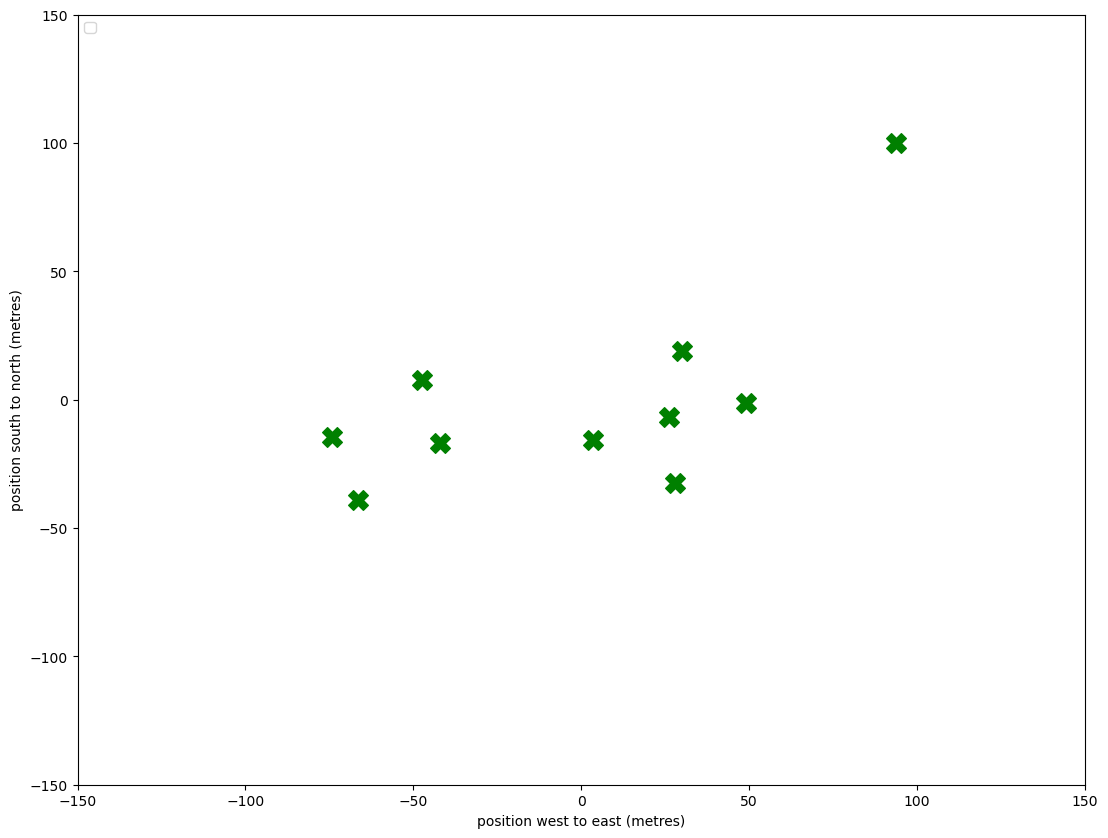

In [5]:
# the pickle file being imported is a list of latitude and longitude coordinates for the recorders being used. Code is written and tested for 10 recorders.
with open('apr27_2024_coordinates.pickle', "rb") as input_file:
    recorder_locations = pickle.load(input_file)
print(recorder_locations)
metric_coords = turn_coords_to_metric_grid(recorder_locations)
if len(metric_coords[0]) != 3:
    metric_coords = np.array([coord + [0] for coord in metric_coords])
altitudes = [3, 3.5, 3.5, 4, 1, 4.5, 0, 0, 0, 3.5]
for i, alt in enumerate(altitudes):
    metric_coords[i][2] = altitudes[i]
print(metric_coords)
# displays recorder array
show_2d_plot(metric_coords, [[0,0,0]], [0,0,0], 150, 150)

In [10]:
# import the list of wave files from the recording session
wave_name_list = []
wave_name_stub ='*' + '2024' + '*.wav'
for file in glob.glob(wave_name_stub):
    wave_name_list.append(file)
print(wave_name_list)

['A_20240427_053000.wav', 'B_20240427_053000.wav', 'D_20240427_053000.wav', 'E_20240427_053000.wav', 'HERMIT1_20240427_053206.wav', 'HERMIT1_20240427_063203.wav', 'HERMIT2_20240427_053128.wav', 'HERMIT2_20240427_063103.wav', 'HERMIT3_20240427_053105.wav', 'HERMIT3_20240427_063103.wav', 'HERMIT4_20240427_053048.wav', 'HERMIT4_20240427_063003.wav', 'HERMIT5_20240427_053150.wav', 'HERMIT5_20240427_063103.wav', 'HERMIT6_20240427_053139.wav', 'HERMIT6_20240427_063103.wav']


In [11]:
# create spectrograms for each wave
create_spec_files(wave_name_list)

In [12]:
# group wave names by recorder if there are multiple wave files per recorder
recorder_wavenames = ['A', 'B', 'D', 'E', 'HERMIT1', 'HERMIT2', 'HERMIT3', 'HERMIT4', 'HERMIT5', 'HERMIT6']
wave_name_array = []
for rec_name in recorder_wavenames:
    temp_list = []
    for wave_name in wave_name_list:
        if rec_name + '_' in wave_name and len(temp_list) < 2:
            temp_list.append(wave_name)
    wave_name_array.append(temp_list)
print(wave_name_array)
mini_wavenames_by_rec = wave_name_array[4:]
print(mini_wavenames_by_rec)

[['A_20240427_053000.wav'], ['B_20240427_053000.wav'], ['D_20240427_053000.wav'], ['E_20240427_053000.wav'], ['HERMIT1_20240427_053206.wav', 'HERMIT1_20240427_063203.wav'], ['HERMIT2_20240427_053128.wav', 'HERMIT2_20240427_063103.wav'], ['HERMIT3_20240427_053105.wav', 'HERMIT3_20240427_063103.wav'], ['HERMIT4_20240427_053048.wav', 'HERMIT4_20240427_063003.wav'], ['HERMIT5_20240427_053150.wav', 'HERMIT5_20240427_063103.wav'], ['HERMIT6_20240427_053139.wav', 'HERMIT6_20240427_063103.wav']]
[['HERMIT1_20240427_053206.wav', 'HERMIT1_20240427_063203.wav'], ['HERMIT2_20240427_053128.wav', 'HERMIT2_20240427_063103.wav'], ['HERMIT3_20240427_053105.wav', 'HERMIT3_20240427_063103.wav'], ['HERMIT4_20240427_053048.wav', 'HERMIT4_20240427_063003.wav'], ['HERMIT5_20240427_053150.wav', 'HERMIT5_20240427_063103.wav'], ['HERMIT6_20240427_053139.wav', 'HERMIT6_20240427_063103.wav']]


In [13]:
# store the lengths of each wave
wavelengths = []
for rec in mini_wavenames_by_rec:
    temp_list = []
    for wavename in rec:
        duration = librosa.get_duration(path=wavename)
        temp_list.append(duration)
    wavelengths.append(temp_list)
wavelengths

with open('wavelengths' + '_04-27-2024' + '.pickle', 'wb') as f:
    pickle.dump(wavelengths, f)

In [14]:
# import the sonic visualizer files that store a synchronized clap at beginning and end of each recording
# sonic vizualiser files are named as clap_root eg: clap_frye1_B_0_jun12-2023
recorder_names = ['A', 'B', 'D', 'E', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']

clap_ts_name_list = []
clap_ts_name_stub ='clap_' + '*'
for file in glob.glob(clap_ts_name_stub):
    clap_ts_name_list.append(file)
print("here:", clap_ts_name_list)

def group_by_rec(clap_ts_name_list, recorder_names):
    sorted_clap_names = []
    for rec in recorder_names:
        temp_list = []
        for clap in clap_ts_name_list:
            if '_' + rec + '_' in clap and len(temp_list) < 2:
                temp_list.append(clap)
        sorted_clap_names.append(temp_list)
    return sorted_clap_names
sorted_clap_names = group_by_rec(clap_ts_name_list, recorder_names)
print("clap names: ", sorted_clap_names)

here: ['clap_frye1_H2_0_04-27-2024.csv', 'clap_frye1_H2_1_04-27-2024.csv', 'clap_frye3_A_0_04-27-2024.csv', 'clap_frye3_B_0_04-27-2024.csv', 'clap_frye3_D_0_04-27-2024.csv', 'clap_frye3_E_0_04-27-2024.csv', 'clap_frye3_H6_0_04-27-2024.csv', 'clap_frye3_H6_1_04-27-2024.csv', 'clap_frye4_H1_0_04-27-2024.csv', 'clap_frye4_H1_1_04-27-2024.csv', 'clap_frye4_H3_0_04-27-2024.csv', 'clap_frye4_H3_1_04-27-2024.csv', 'clap_frye4_H4_0_04-27-2024.csv', 'clap_frye4_H4_1_04-27-2024.csv', 'clap_frye4_H5_0_04-27-2024.csv', 'clap_frye4_H5_1_04-27-2024.csv']
clap names:  [['clap_frye3_A_0_04-27-2024.csv'], ['clap_frye3_B_0_04-27-2024.csv'], ['clap_frye3_D_0_04-27-2024.csv'], ['clap_frye3_E_0_04-27-2024.csv'], ['clap_frye4_H1_0_04-27-2024.csv', 'clap_frye4_H1_1_04-27-2024.csv'], ['clap_frye1_H2_0_04-27-2024.csv', 'clap_frye1_H2_1_04-27-2024.csv'], ['clap_frye4_H3_0_04-27-2024.csv', 'clap_frye4_H3_1_04-27-2024.csv'], ['clap_frye4_H4_0_04-27-2024.csv', 'clap_frye4_H4_1_04-27-2024.csv'], ['clap_frye4_H5_0_0

In [19]:
# produce the differences in timing between each song
# rootname is birdID_recorder_hour_month#-day#-year eg: frye1_A_0_06-12-2023
rootnames = ['frye4_H1_0_04-27-2024', 'frye4_H1_1_04-27-2024']
template_table_name = 'frye4_for_template_H1_0_04-27-2024.txt'

song_limit = 4000
produce_all_lags(rootnames, song_limit, metric_coords, template_table_name)

producing lags for frye4_H1_0_04-27-2024
['A' 'B' 'C' 'D' 'E' 'F' 'G' nan 'H']
on A:  108.817813948 lag: 0.200217576, valley score: 5.275479316711426
on B:  157.464525966 lag: 0.200217576, valley score: 4.290992736816406
on H3:  125.8255708137003 lag: -9.585329969752365e-05, valley score: 12.172289848327637
on H4:  143.01180553319145 lag: -0.0006944668085395733, valley score: 11.547657012939453
on H5:  80.11727761787363 lag: -0.0003057151263732294, valley score: 11.78439712524414
1 songs done in 0:00:34.335123-------------------------------
on A:  2289.076835028234 lag: 0.2227057820000482, valley score: 1.3209590911865234
on H3:  2304.998494188875 lag: 0.0709958947004452, valley score: 4.852298259735107
on H4:  2322.204655833611 lag: 0.08490580119132574, valley score: 2.2794809341430664
on H5:  2259.1881492495413 lag: -0.03294988512652708, valley score: 1.2084732055664062
2 songs done in 0:00:51.452637-------------------------------
on A:  2292.630706943074 lag: 0.21254981799984307, va

C:\Users\newblearbomb\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


on H4:  nan lag: nan, valley score: nan
on H5:  3490.6350803319147 lag: 0.0816674228735792, valley score: 3.3333358764648438
211 songs done in 1:14:53.808677-------------------------------
on A:  3525.6061458569325 lag: 0.06891546999986531, valley score: 1.0484485626220703
on B:  3574.28551549469 lag: 0.10446134399990115, valley score: 1.4792156219482422
on H3:  3540.876920657847 lag: -0.09004867729981925, valley score: 4.356288433074951
on H4:  3.2116723149395296 lag: -0.019555542808562087, valley score: 2.9846343994140625
on H5:  3495.3366640691806 lag: 0.07513858887341485, valley score: 2.2061290740966797
212 songs done in 1:15:16.588687-------------------------------
on A:  3529.4634721681664 lag: 0.06891546999986531, valley score: 1.046370506286621
on B:  3578.150092805403 lag: 0.1117156039999827, valley score: 1.568099021911621
on H3:  3544.7387682626563 lag: -0.0835198432996549, valley score: 3.931417942047119
on H4:  7.063373542119572 lag: -0.02318267280856201, valley score: 3.

fla length:  232 || fv length:  232 || signals:  10 || times:  10
song 0:  [ 0.21770532         nan         nan         nan  0.                 nan
  0.07099589  0.08204918 -0.03572081         nan]
-----------------
song 1:  [0.20889218 0.27412065        nan        nan 0.                nan
 0.06229078 0.07620069 0.02921354        nan]
-----------------
song 2:  [0.20641837        nan        nan        nan 0.                nan
 0.07027047 0.07402441 0.0816882         nan]
-----------------
song 3:  [0.21620021 0.1971055         nan        nan 0.                nan
 0.07317217 0.07402441        nan        nan]
-----------------
song 4:  [0.2207973         nan        nan        nan 0.                nan
 0.06156536 0.06967186 0.06627406        nan]
-----------------
song 5:  [0.23644507 0.27728945        nan        nan 0.                nan
 0.06736876 0.068221   0.06788433        nan]
-----------------
song 6:  [0.22982374 0.26381434        nan        nan 0.                nan
 0.06301

C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_22600\1723279533.py:1980: RuntimeWarning: Mean of empty slice
  centroid = np.nanmean(array2d, axis=0)


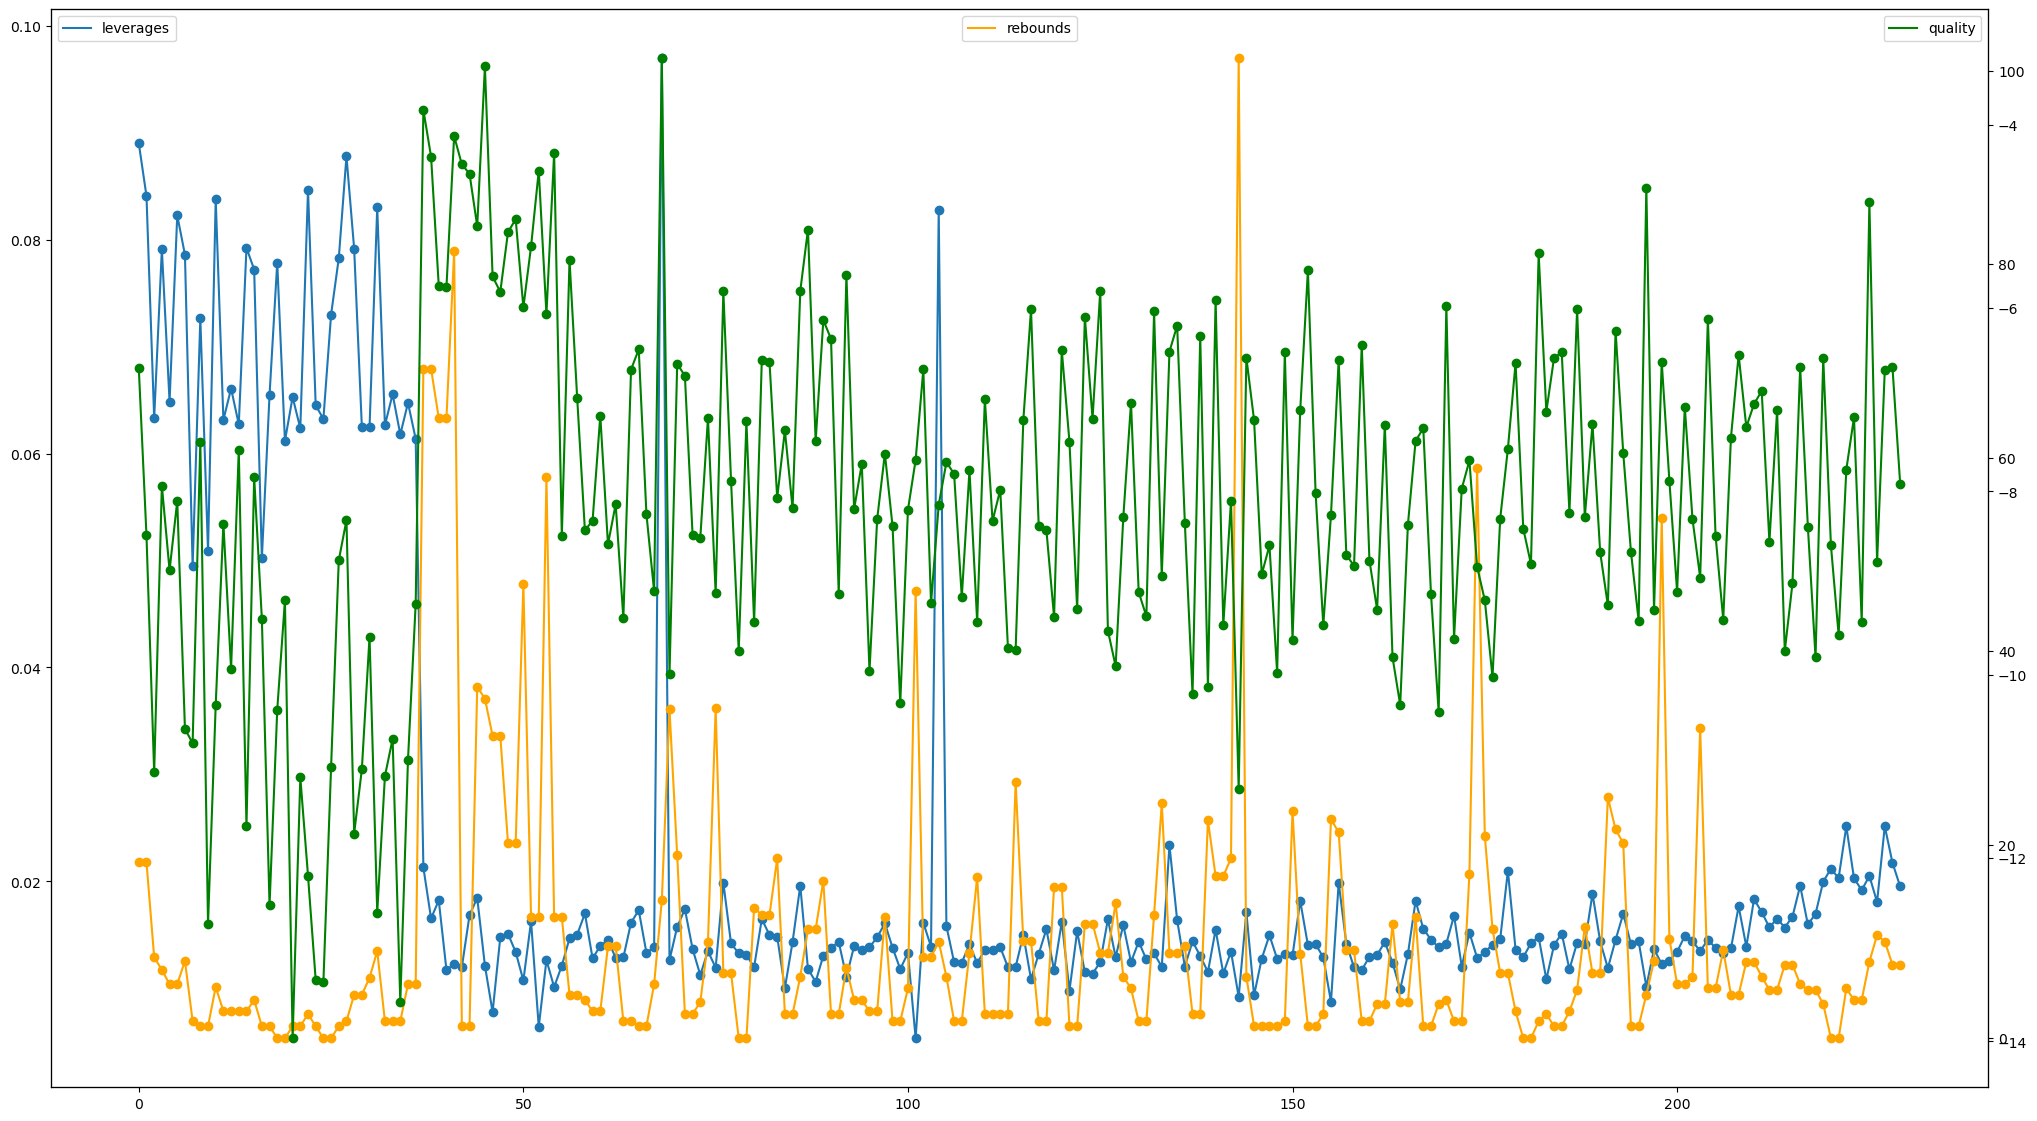

greyed out:  0
greyed out:  37
greyed out:  38
greyed out:  39
greyed out:  40
greyed out:  41
greyed out:  44
greyed out:  45
greyed out:  46
greyed out:  47
greyed out:  48
greyed out:  49
greyed out:  50
greyed out:  53
greyed out:  70
greyed out:  89
greyed out:  101
greyed out:  120
greyed out:  140
greyed out:  156
greyed out:  173
greyed out:  192
greyed out:  193
greyed out:  198


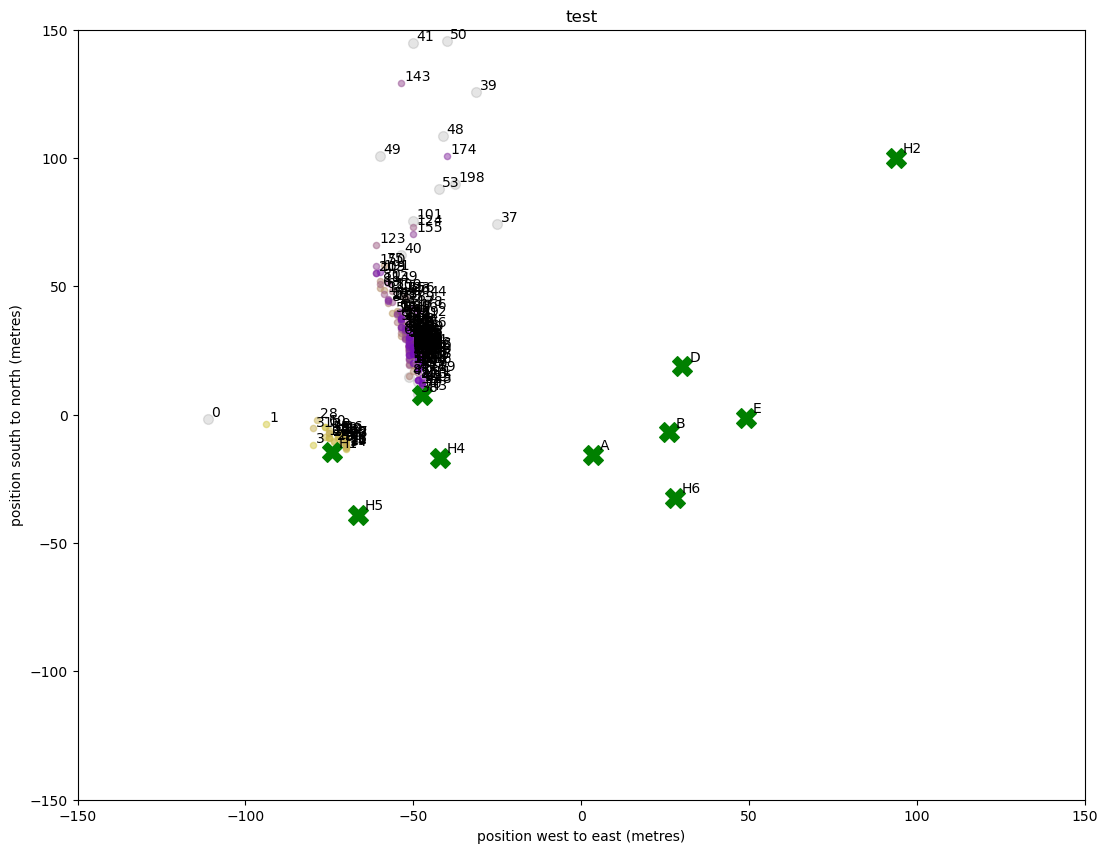

break points:  [36]
good times:  [2292.4181571250742, 2301.0482572443475, 2305.234434627825, 2310.5404805005305, 2319.1439193708384, 2323.4011989354117, 2331.8624322038872, 2335.470898713667, 2339.6748517972487, 2344.438738815784, 2349.7092339086025, 2357.3616722010283, 2361.9478028378453, 2370.7023345397156, 2375.3684558269997, 2378.7813896346356, 2382.914239918802, 2386.931548151293, 2391.322143785776, 2400.9743483438947, 2408.3779274541866, 2413.292907923605, 2421.7097019418215, 2425.8692151558225, 2430.197598141133, 2435.583634665306, 2443.2538492771564, 2446.88009148704, 2451.066268870518, 2458.5320623108523, 2462.478267742927, 2466.744435777873, 2472.663741625295, 2477.8720217667496, 2481.933768630179, 2487.373132873985, 2545.561884196633, 2549.3836591076592, 2588.4457583141075, 2594.8805611474136, 2610.6209430041317, 2621.9796147772304, 2625.9080445082004, 2629.712043720124, 2634.84033321111, 2643.2393509089015, 2647.532182494004, 2652.224966712123, 2657.2999291037986, 2666.2411

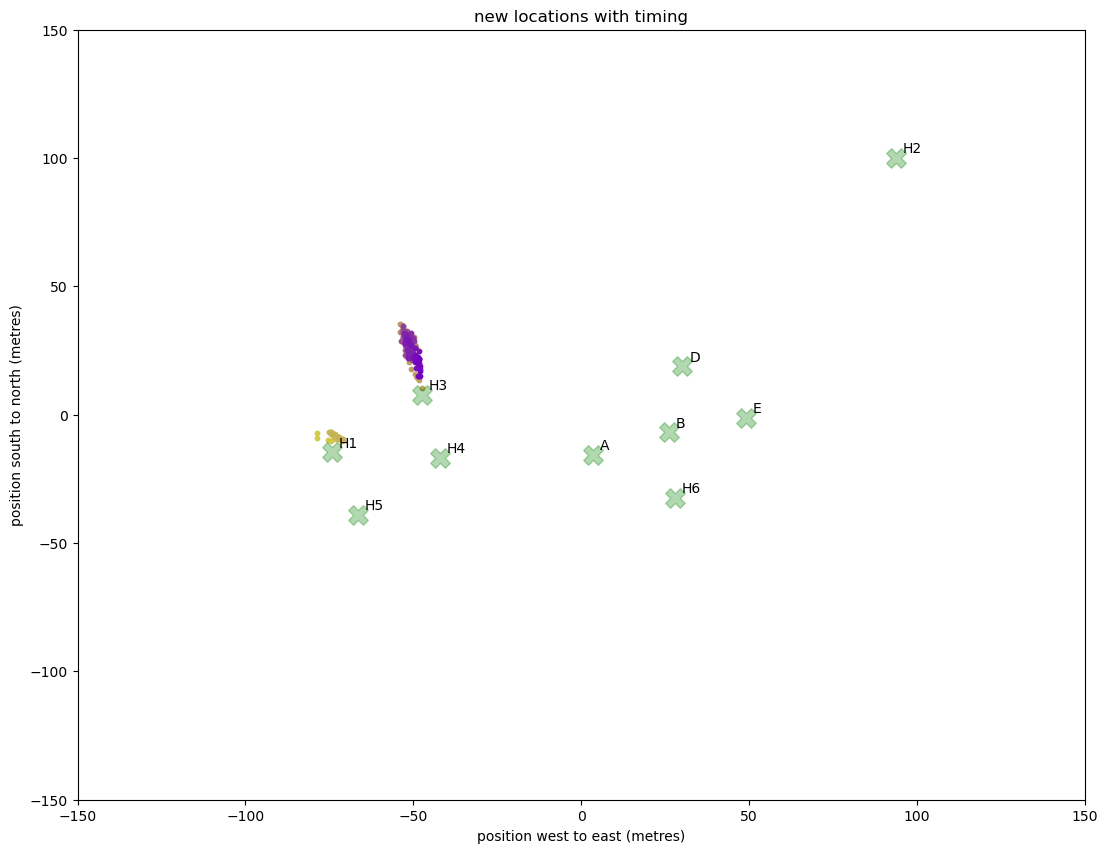

64
   BirdID    RecA Time RecID   OGRec Time  OG Location  Good Location  \
0   frye4  2296.879858    H1  2252.411770          NaN            NaN   
1   frye4  2315.011069    H1  2270.533599          NaN            NaN   
2   frye4  2327.862900    H1  2283.378780          NaN            NaN   
3   frye4  2353.459907    H1  2308.962541          NaN            NaN   
4   frye4  2366.080653    H1  2321.576757          NaN            NaN   
..    ...          ...   ...          ...          ...            ...   
59  frye4  3493.620962    H1  3448.533616          NaN            NaN   
60  frye4  3533.936248    H1  3488.828041          NaN            NaN   
61  frye4  3552.698498    H1  3507.580582          NaN            NaN   
62  frye4  3581.770655    H1  3536.637695          NaN            NaN   
63  frye4  3629.791706    H1  3584.633898          NaN            NaN   

    Av Location  Had OG  Leashed  Bifabs  Jumped ID  Low Freq (Hz)  \
0           NaN       0        0       0       0  

C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_22600\1723279533.py:1980: RuntimeWarning: Mean of empty slice
  centroid = np.nanmean(array2d, axis=0)


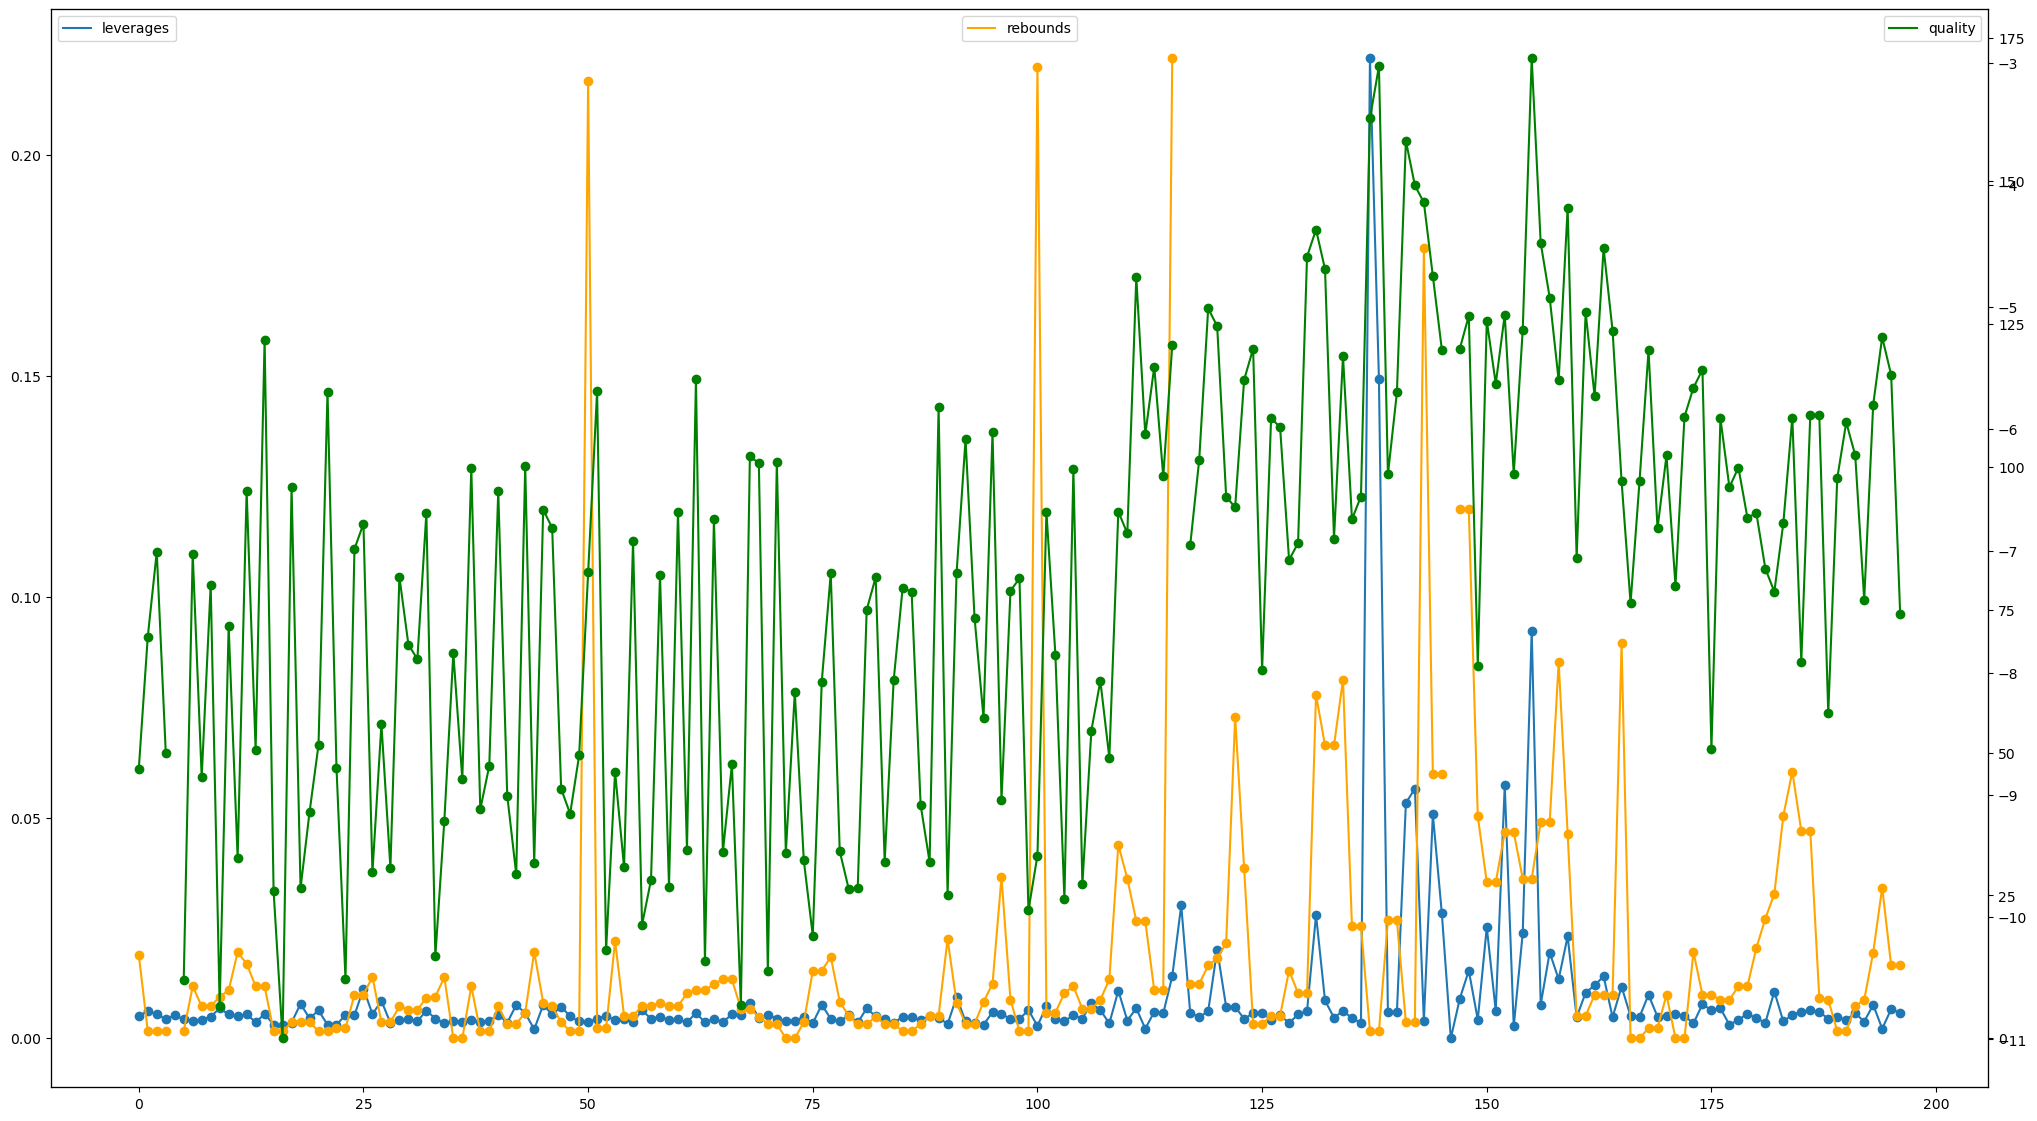

greyed out:  50
greyed out:  109
greyed out:  110
greyed out:  111
greyed out:  112
greyed out:  115
greyed out:  121
greyed out:  122
greyed out:  123
greyed out:  131
greyed out:  132
greyed out:  133
greyed out:  134
greyed out:  135
greyed out:  136
greyed out:  139
greyed out:  140
greyed out:  143
greyed out:  144
greyed out:  145
greyed out:  147
greyed out:  148
greyed out:  149
greyed out:  150
greyed out:  151
greyed out:  152
greyed out:  153
greyed out:  154
greyed out:  155
greyed out:  156
greyed out:  157
greyed out:  158
greyed out:  159
greyed out:  165
greyed out:  173
greyed out:  180
greyed out:  181
greyed out:  182
greyed out:  183
greyed out:  184
greyed out:  185
greyed out:  186
greyed out:  194


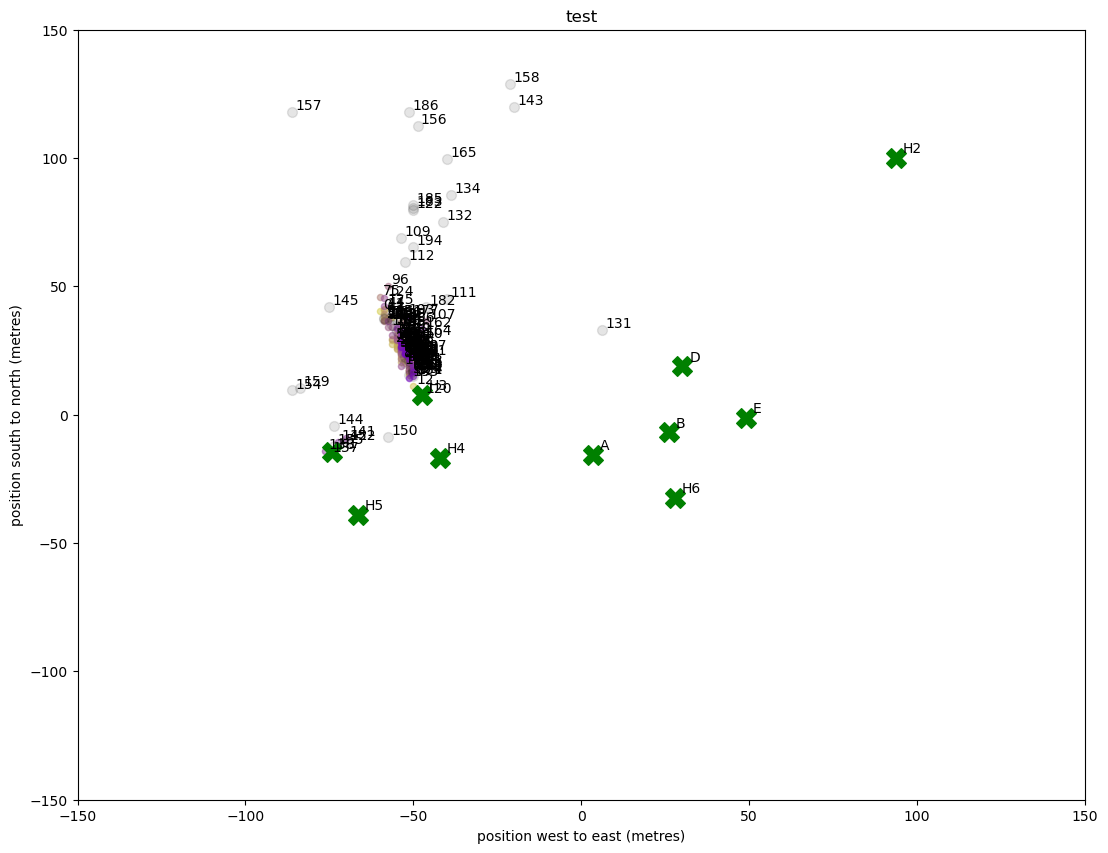

break points:  [120, 124]
120 124
good times:  [3648.7121053331566, 3653.9570360025664, 3669.2796895261636, 3677.6164929329316, 3689.241800826909, 3697.7563612347167, 3706.750865507311, 3711.6569587469985, 3715.7986969192366, 3720.242621955222, 3728.241687019996, 3733.3255372607227, 3738.0005464370793, 3742.640004175208, 3746.9239479102575, 3756.2561904848267, 3765.552881699208, 3770.1567880361285, 3774.7606943740493, 3780.075628717128, 3786.088500580642, 3795.5807244961666, 3800.735677537309, 3810.1745743135016, 3815.3473030947684, 3819.666798230027, 3825.3016951749755, 3830.190012714559, 3835.131657393475, 3845.7793017797353, 3852.071899630531, 3856.2847405651646, 3860.4620301376112, 3870.3630951175064, 3875.5180481596494, 3880.370814298025, 3884.3881225695354, 3889.152010208392, 3900.9195237032004, 3910.785037321908, 3921.8948499118706, 3926.889821691099, 3931.120438325837, 3939.4394659924806, 3946.33643764881, 3950.673708523192, 3955.7575587639185, 3960.237035200112, 3969.782586176

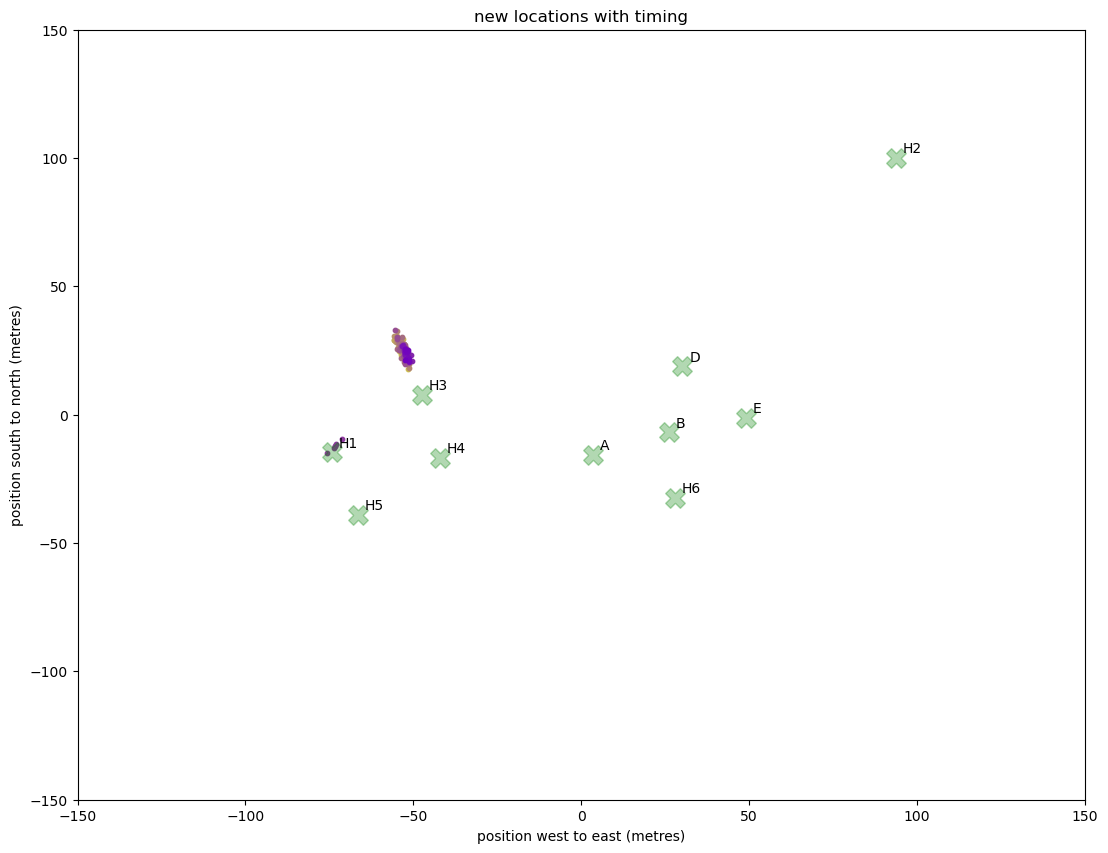

56
   BirdID    RecA Time RecID   OGRec Time  OG Location  Good Location  \
0   frye4  3644.407114    H1     2.305276          NaN            NaN   
1   frye4  3673.954699    H1    31.837572          NaN            NaN   
2   frye4  3693.561296    H1    51.434023          NaN            NaN   
3   frye4  3702.715782    H1    60.583772          NaN            NaN   
4   frye4  3724.153276    H1    82.010174          NaN            NaN   
5   frye4  3751.314546    H1   109.157389          NaN            NaN   
6   frye4  3760.966751    H1   118.804599          NaN            NaN   
7   frye4  3790.603528    H1   148.426041          NaN            NaN   
8   frye4  3805.321808    H1   163.136705          NaN            NaN   
9   frye4  3840.553246    H1   198.349912          NaN            NaN   
10  frye4  3865.616983    H1   223.400680          NaN            NaN   
11  frye4  3896.280066    H1   254.047896          NaN            NaN   
12  frye4  3905.932271    H1   263.695106       

C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_22600\1723279533.py:1980: RuntimeWarning: Mean of empty slice
  centroid = np.nanmean(array2d, axis=0)


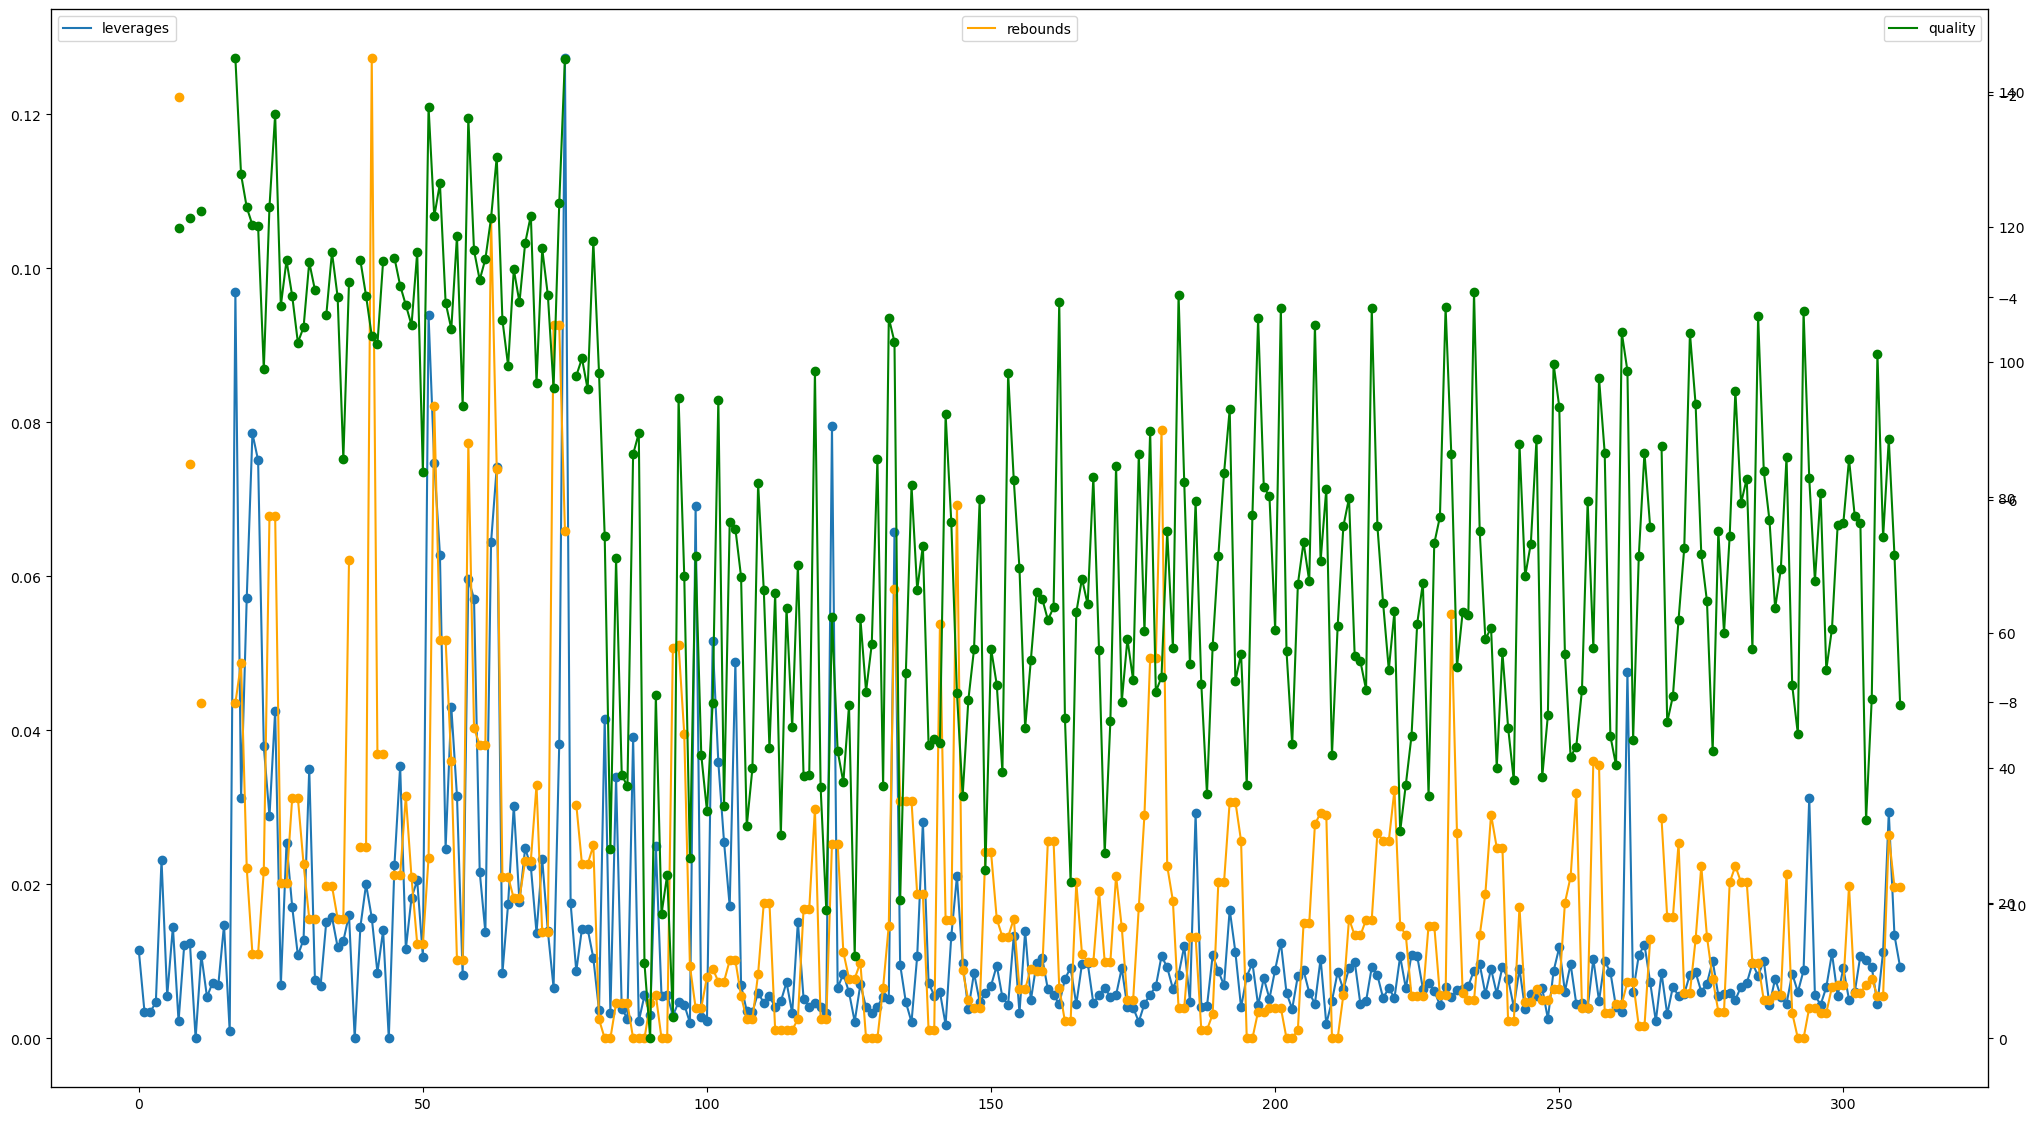

greyed out:  7
greyed out:  9
greyed out:  11
greyed out:  17
greyed out:  18
greyed out:  19
greyed out:  22
greyed out:  23
greyed out:  24
greyed out:  25
greyed out:  26
greyed out:  27
greyed out:  28
greyed out:  29
greyed out:  30
greyed out:  31
greyed out:  33
greyed out:  34
greyed out:  35
greyed out:  36
greyed out:  37
greyed out:  39
greyed out:  40
greyed out:  41
greyed out:  42
greyed out:  43
greyed out:  45
greyed out:  46
greyed out:  47
greyed out:  48
greyed out:  51
greyed out:  52
greyed out:  53
greyed out:  54
greyed out:  55
greyed out:  58
greyed out:  59
greyed out:  60
greyed out:  61
greyed out:  62
greyed out:  63
greyed out:  64
greyed out:  65
greyed out:  66
greyed out:  67
greyed out:  68
greyed out:  69
greyed out:  70
greyed out:  71
greyed out:  72
greyed out:  73
greyed out:  74
greyed out:  75
greyed out:  77
greyed out:  78
greyed out:  79
greyed out:  80
greyed out:  95
greyed out:  96
greyed out:  110
greyed out:  119
greyed out:  122
greyed 

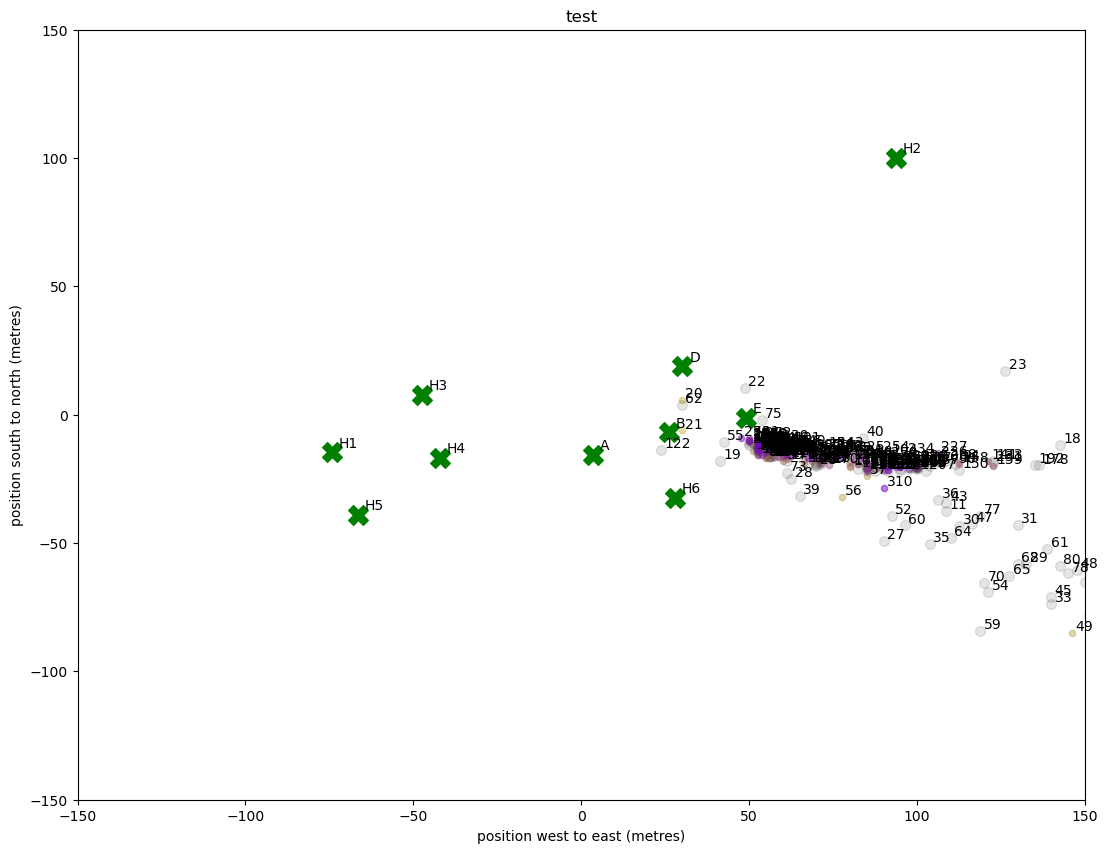

break points:  [2]
good times:  [1420.8521660357649, 1435.9218221845495, 1598.1818486371037, 1605.7979460435772, 1637.0458672013553, 1645.0626433434154, 1798.0636285955254, 1804.0951163218847, 1809.2731337659202, 1813.0579626599908, 1817.5393858290438, 1821.742171288104, 1826.8737491138072, 1831.891039625303, 1836.0687935435742, 1870.7824082468612, 1878.212747180006, 1881.9046968374125, 1888.3830235947482, 1894.605932451257, 1911.1616563866708, 1915.5037607007275, 1930.3876583761837, 1935.890753148544, 1943.1585534175267, 1956.2777455963608, 1961.1539055212372, 1977.8025086933153, 1981.7963158698808, 1986.0919805656051, 1994.7529693845524, 1999.4433708361, 2004.6524631536665, 2014.5130269848846, 2019.4588463372593, 2024.033148742977, 2031.4170480577895, 2040.1941359225673, 2045.139955274942, 2049.7374774898253, 2055.3566713080163, 2066.3628608527374, 2073.305583793395, 2084.3349931472817, 2091.138397232943, 2096.478953341141, 2102.051707541, 2111.432510444095, 2115.7513949489858, 2121.

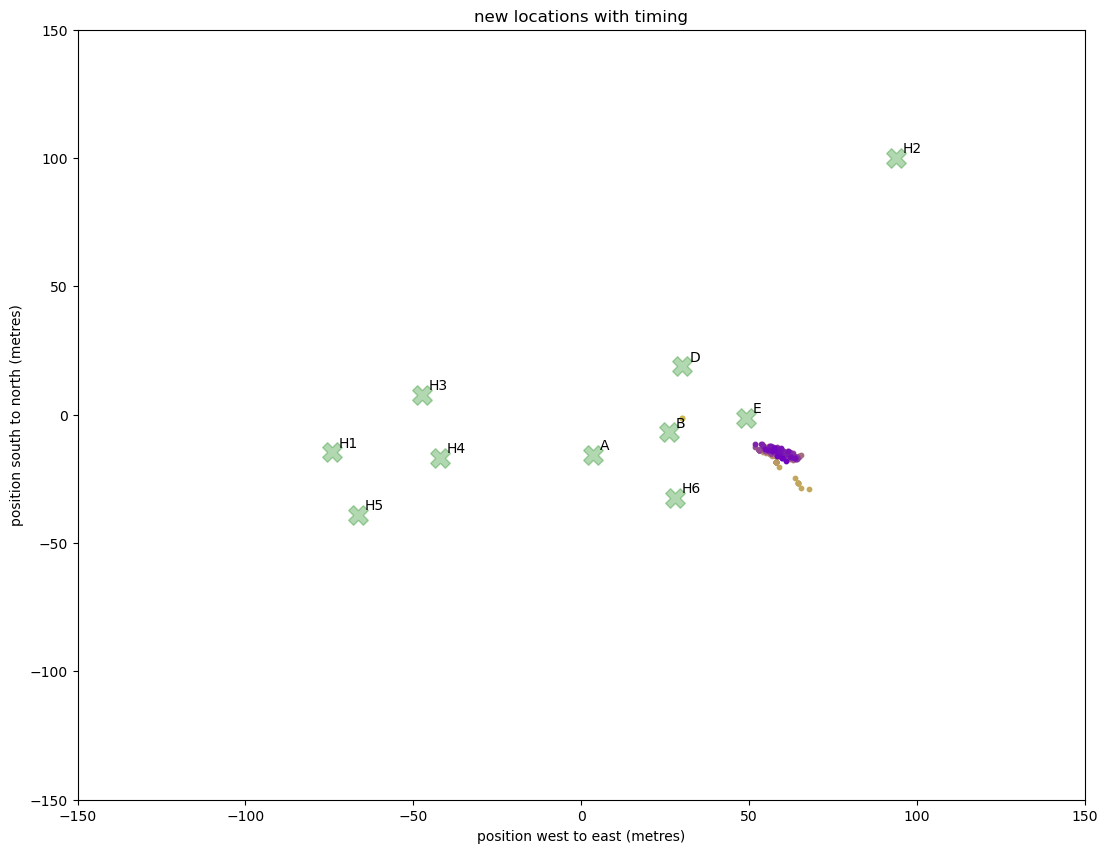

42
   BirdID    RecA Time RecID   OGRec Time  OG Location  Good Location  \
0   frye3  1428.174283     E  1493.175057          NaN            NaN   
1   frye3  1528.705765     E  1593.706559          NaN            NaN   
2   frye3  1555.622008     E  1620.622808          NaN            NaN   
3   frye3  1568.467186     E  1633.467989          NaN            NaN   
4   frye3  1602.383431     E  1667.384241          NaN            NaN   
5   frye3  1624.005258     E  1689.006073          NaN            NaN   
6   frye3  1658.756527     E  1723.757349          NaN            NaN   
7   frye3  1665.685462     E  1730.686285          NaN            NaN   
8   frye3  1678.761603     E  1743.762429          NaN            NaN   
9   frye3  1707.720995     E  1772.721827          NaN            NaN   
10  frye3  1740.082667     E  1805.083506          NaN            NaN   
11  frye3  1753.383053     E  1818.383894          NaN            NaN   
12  frye3  1776.388502     E  1841.389348       

C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_22600\1723279533.py:1980: RuntimeWarning: Mean of empty slice
  centroid = np.nanmean(array2d, axis=0)


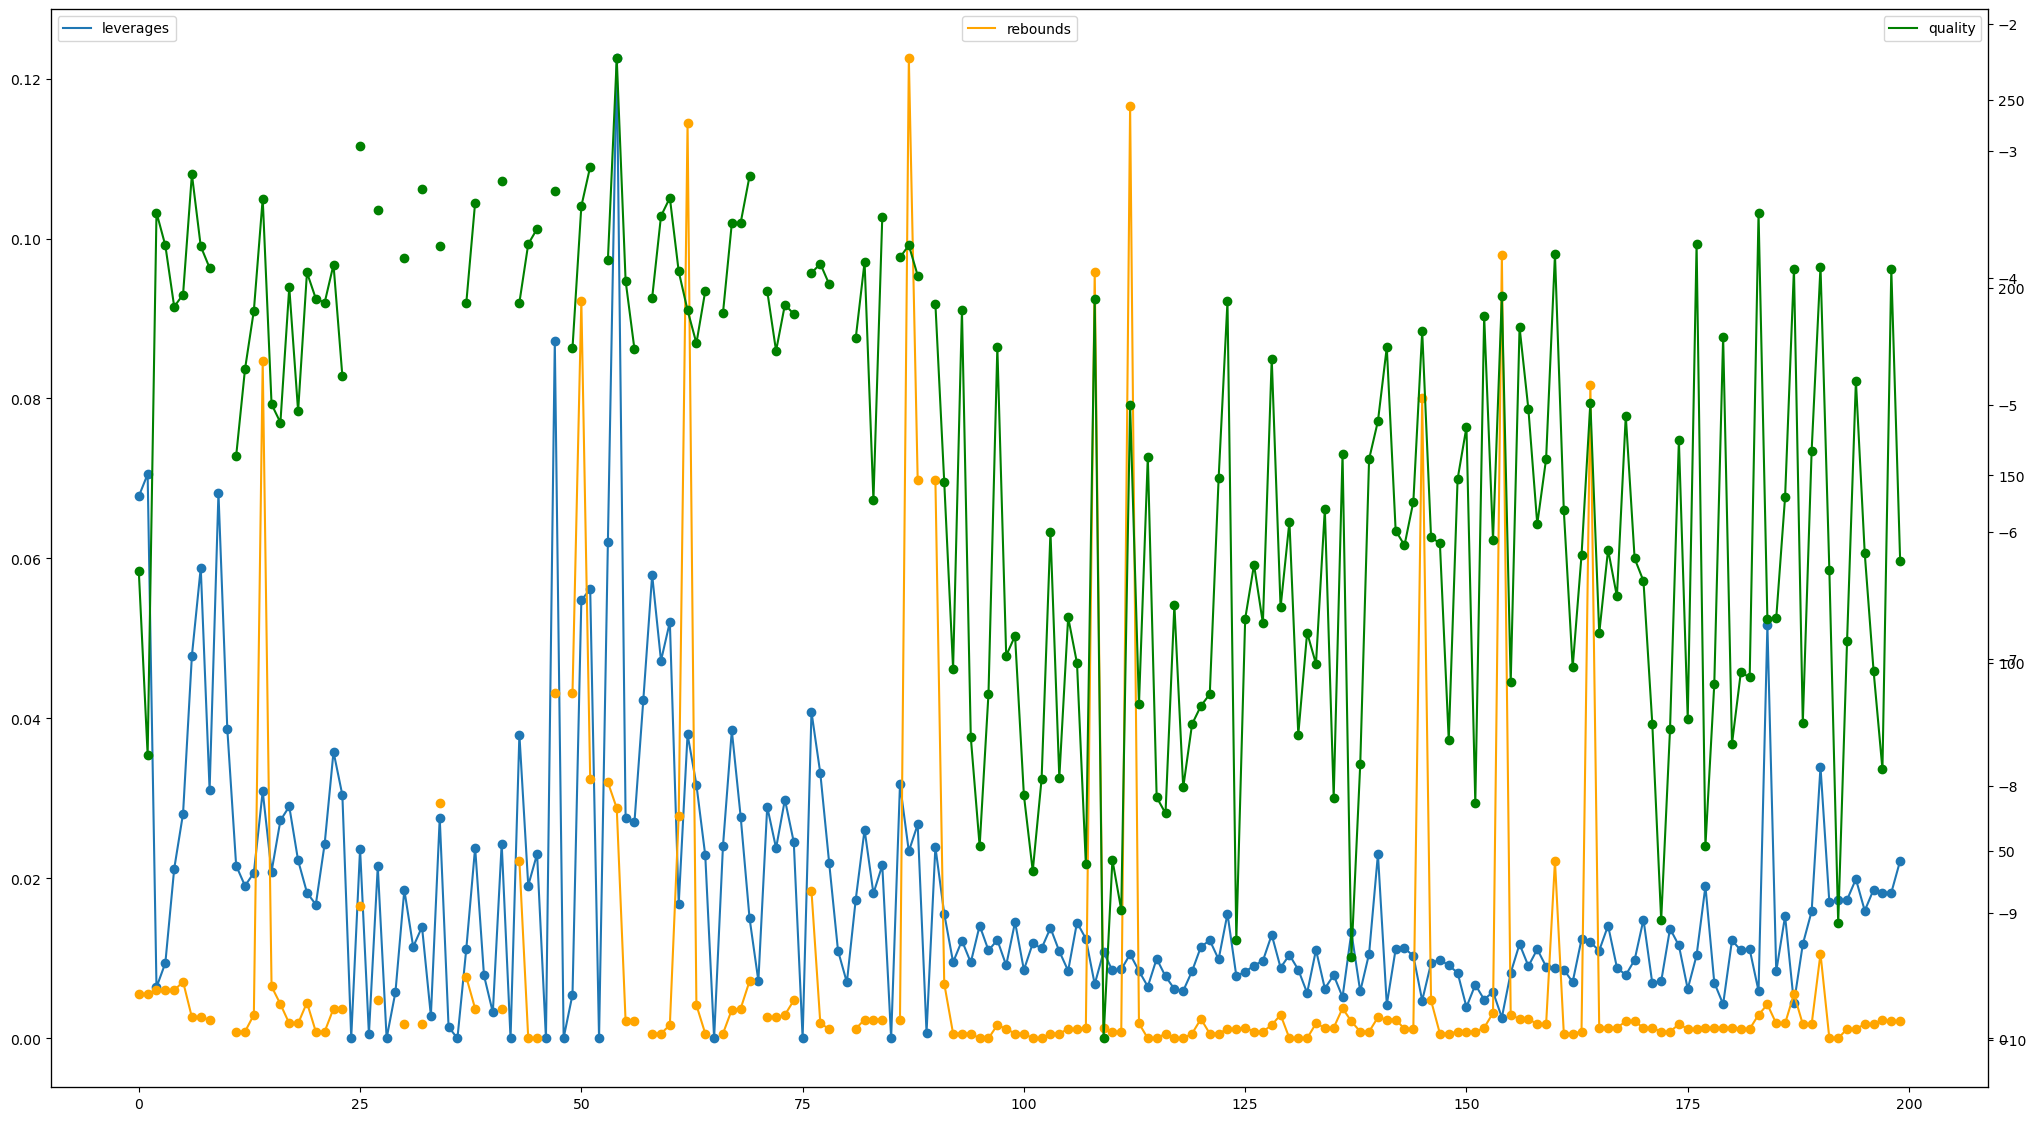

greyed out:  5
greyed out:  14
greyed out:  25
greyed out:  34
greyed out:  37
greyed out:  43
greyed out:  47
greyed out:  49
greyed out:  50
greyed out:  51
greyed out:  53
greyed out:  54
greyed out:  61
greyed out:  62
greyed out:  69
greyed out:  76
greyed out:  87
greyed out:  88
greyed out:  90
greyed out:  108
greyed out:  112
greyed out:  145
greyed out:  154
greyed out:  160
greyed out:  164
greyed out:  190


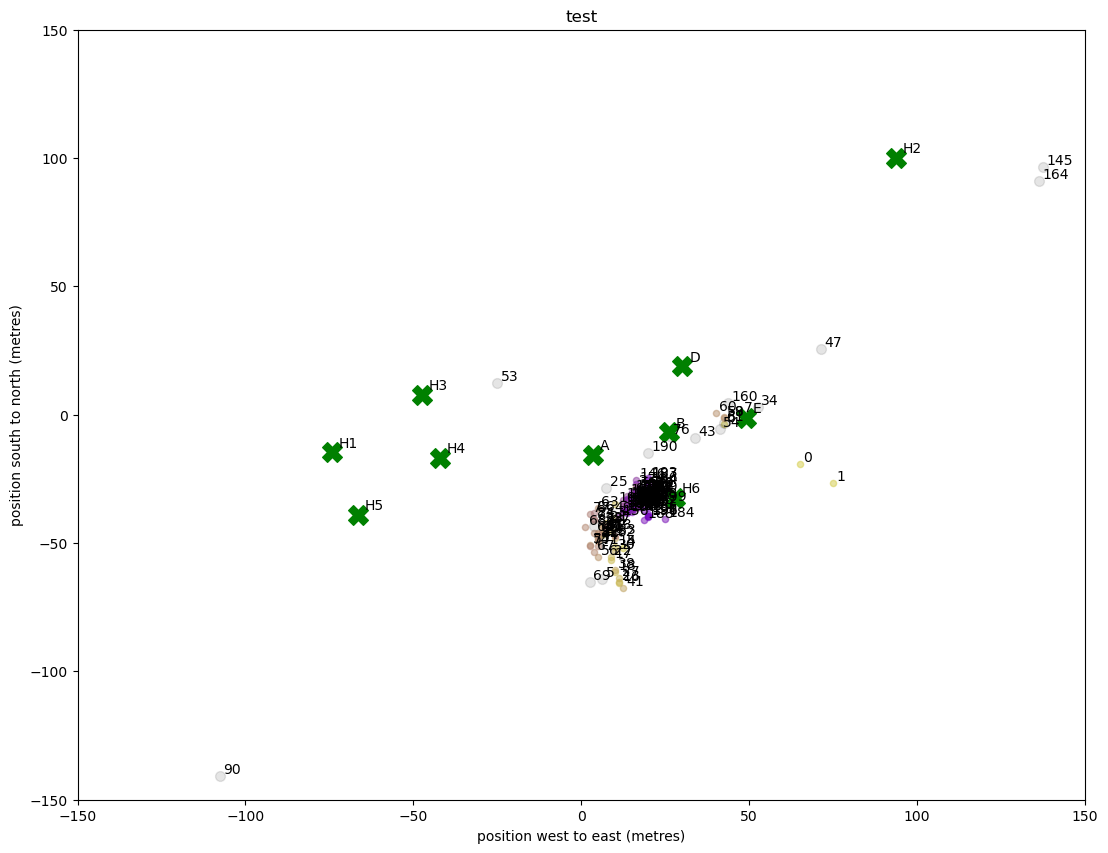

break points:  [2, 5, 7, 29, 32, 138]
2 5
5 7
7 29
29 32
32 138
good times:  [3603.7479954086953, 3609.356223788383, 3632.109099527094, 3636.9974126534894, 3657.297243986474, 3675.499544548827, 3680.5922765440932, 3685.578355932797, 3717.9478768158206, 3724.969272080959, 3730.4175192561183, 3748.8597916012523, 3762.413750772966, 3768.733006515893, 3776.767615728199, 3782.953553840706, 3788.1973806492215, 3793.49453455793, 3799.484940097797, 3807.0307180445875, 3936.686558413239, 4008.2514613249846, 4047.615713899038, 4114.541164806969, 4142.306781962694, 4174.320789162598, 4192.2831179891955, 4280.859349130769, 4288.99172310661, 4316.650686109973, 4341.706364827979, 4351.749624844836, 4374.138099059399, 4387.007694391957, 4408.916225136008, 4413.715659842123, 4435.606413356321, 4460.287950867129, 4472.242098468805, 4483.271910498568, 4494.914983629263, 4532.4216772144655, 4541.638369466519, 4565.520001144784, 4577.474148747459, 4583.695638181054, 4598.67165212727, 4624.65970237117, 466

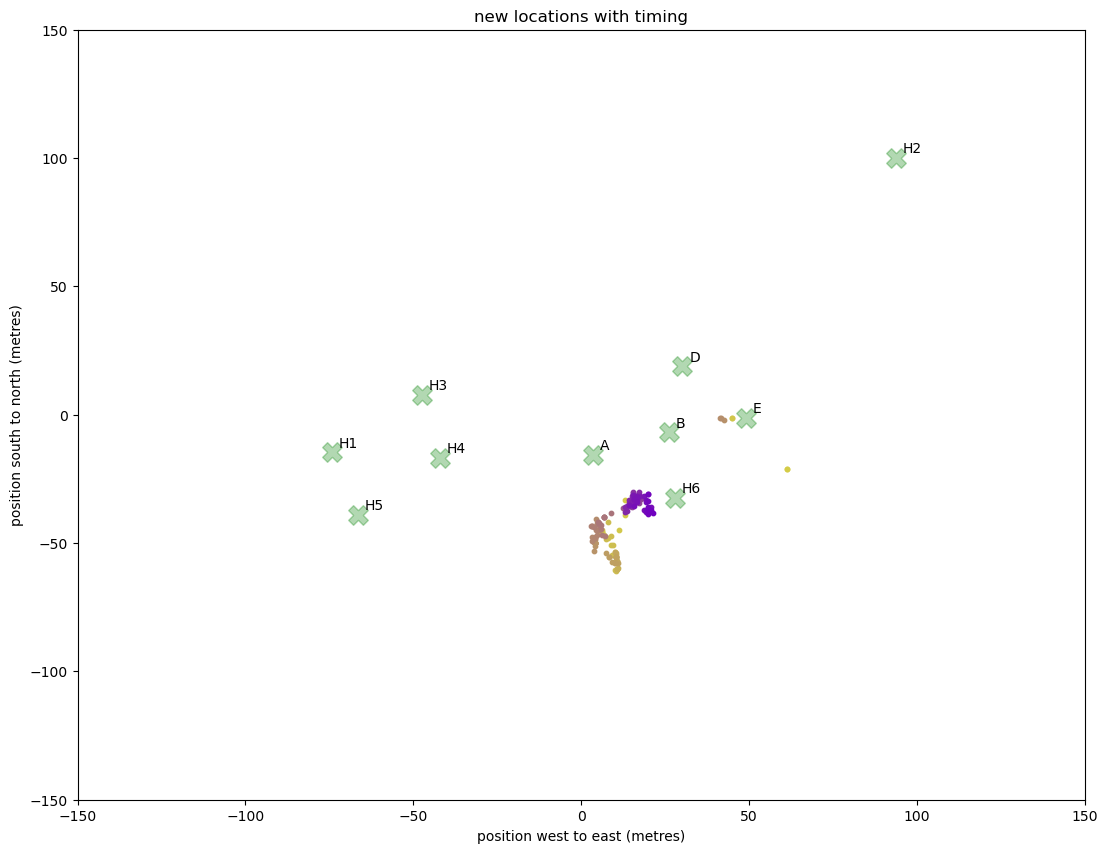

56
   BirdID    RecA Time RecID   OGRec Time  OG Location  Good Location  \
0   frye3  3652.915538    H6    69.733521          NaN            NaN   
1   frye3  3668.780336    H6    85.590124          NaN            NaN   
2   frye3  3692.324228    H6   109.121854          NaN            NaN   
3   frye3  3736.967859    H6   153.742424          NaN            NaN   
4   frye3  3753.703666    H6   170.469586          NaN            NaN   
5   frye3  3860.242229    H6   276.953117          NaN            NaN   
6   frye3  3875.484878    H6   292.187892          NaN            NaN   
7   frye3  3891.998488    H6   308.692973          NaN            NaN   
8   frye3  3903.232721    H6   319.921402          NaN            NaN   
9   frye3  3943.699066    H6   360.366844          NaN            NaN   
10  frye3  3958.026267    H6   374.686645          NaN            NaN   
11  frye3  3980.343639    H6   396.992488          NaN            NaN   
12  frye3  4003.700886    H6   420.337670       

In [31]:
# produce position estimates based on lags
rootnames = [
'frye4_H1_0_04-27-2024', 'frye4_H1_1_04-27-2024', 'frye3_E_0_04-27-2024', 'frye3_H6_1_04-27-2024' 
]

for rootname in rootnames:
    
    with open('fla_' + rootname + '.pickle', "rb") as input_file:
        fine_lags_array = pickle.load(input_file)
    with open('fv_' + rootname + '.pickle', "rb") as input_file:
        valley_scores_array = pickle.load(input_file)
    with open('signals_' + rootname + '.pickle', "rb") as input_file:
        signal_array_by_rec = pickle.load(input_file)
    with open('times_' + rootname + '.pickle', "rb") as input_file:
        song_times_with_claps = pickle.load(input_file)
    
    print("fla length: ",  len(fine_lags_array),  "|| fv length: ", len(valley_scores_array), "|| signals: ", len(signal_array_by_rec), "|| times: ", len(song_times_with_claps))
    ref_name = rootname.split('_')[1]
    ref_index = recorder_names.index(ref_name)
    hour_index = int(rootname.split('_')[2])
    birdID = rootname.split('_')[0]
    
    signal_array_by_rec_2d = []
    for rec in signal_array_by_rec:
        rec_list = []
        for hour in rec:
            for song in hour:
                rec_list.append(song)
        signal_array_by_rec_2d.append(rec_list)
    
    signal_array_by_song = np.array(signal_array_by_rec_2d).transpose()
    nudged_lags = nudge_lags(fine_lags_array, signal_array_by_song, 0.0001683601237319405,  0.009136567147040808, -40)
    
    reffed_nudged_lags = []
    for song in nudged_lags:
        reffed_nudged_lags.append(song - song[ref_index])
    reffed_nudged_lags = np.array(reffed_nudged_lags)
    
    trim_nudged_lags = reffed_nudged_lags[1:-1]
    trim_valley_scores = valley_scores_array[1:-1]
    
    tree_height = 30
    graph_size = 200
    alpha_points, alpha_one_percenters, alpha_scores, alpha_errors = zero_in_on_location(metric_coords, trim_nudged_lags, np.array(trim_valley_scores), graph_size, graph_size, tree_height, ref_index)
    
    average_valley_scores = np.nanmean(trim_valley_scores, axis=1)
    
    b = -3.28134142403055 
    c = 16.0
    outcome_scores = get_outcome_scores(b, average_valley_scores, c, alpha_errors)
    qualities = []
    for i, qual in enumerate(outcome_scores):
        if qual == -1000000:
            qualities.append(np.nan)
        else:
            qualities.append(qual)
    
    leverages = get_leverages(trim_nudged_lags)
    rebounds = get_rebound_distances(alpha_points)
    
    show_mixed_plot(leverages, 'leverages', rebounds, 'rebounds', qualities, 'quality')
    show_2d_all_points_with_grey(metric_coords, alpha_points, 150, 150, 'test', np.array(qualities), rebounds, jitter_max=2)
    
    song_times = song_times_with_claps[0][0][1:-1]
    good_times = []
    good_points = []
    good_lags = []
    good_valleys = []
    og_point_bools = []

    for i, point in enumerate(alpha_points):
        if np.any(np.isnan(point)):
            og_point_bools.append(0)
        else:
            og_point_bools.append(1)
    
    for i, point in enumerate(alpha_points):
        if (qualities[i] > -8 and rebounds[i] > 15) or np.any(np.isnan(point)):
            pass
        else:
            good_times.append(song_times[i])
            good_points.append(alpha_points[i])
            good_lags.append(trim_nudged_lags[i])
            good_valleys.append(trim_valley_scores[i])


    old_good_points = good_points.copy()
    good_points = border_adjust_all_points(good_points, good_lags, metric_coords)
    

#find times where a jump has occurred
    break_points = find_breakpoints(good_points, 20)
    break_times = []
    for i, good_time in enumerate(good_times):
        if i in break_points:
            break_times.append(good_time)
#create boolean list for when jumps have occurred in the original song_time list as opposed to the trimmed good_points list
    jumped = []
    for time in song_times:
        if time in break_times:
            jumped.append(1)
        else:
            jumped.append(0)
    
    meaned_points = make_means_from_cuts(good_points, break_points)
    new_times = []
    good_points_with_gaps = []
    old_good_points_with_gaps = []
    for og_index, time in enumerate(song_times):
        for good_index, good_time in enumerate(good_times):
            if good_time == time:
                new_times.append([og_index, good_index, good_time])
                good_points_with_gaps.append(good_points[good_index])
                old_good_points_with_gaps.append(old_good_points[good_index])
                break
        else:
            new_times.append([og_index, np.nan, time])
            good_points_with_gaps.append([np.nan])
            old_good_points_with_gaps.append([np.nan])
    print("good times: ", good_times)
    print("meaned_points: ", meaned_points)
    
    leashed = []
    for i, good_point in enumerate(good_points_with_gaps):
        if np.any(np.isnan(good_point)) or np.array_equal(good_point, old_good_points_with_gaps[i]):
            leashed.append(0)
        else:
            print("good point HERE: ", good_point, "---so adding 1")
            leashed.append(1)
    
    #print("song times: ", song_times)
    new_points, bifabs = reinsert_locations(good_times, meaned_points, song_times)

    song_values = []
    ref_table = pd.read_csv("raven_" + rootname + ".txt", sep='\t')
    low_ref_table = ref_table[ref_table['Low Freq (Hz)'] < 3000]
    low_ref_table = low_ref_table.sort_values('Begin Time (s)')
    song_types = low_ref_table['ID'].to_numpy()
    low_times = low_ref_table['Begin Time (s)'].to_numpy()
    low_freqs = low_ref_table['Low Freq (Hz)'].to_numpy()
    high_freqs = low_ref_table['High Freq (Hz)'].to_numpy()
    print(len(song_times), len(alpha_points), len(og_point_bools), len(leashed), len(bifabs), len(jumped))

    for i, song in enumerate(song_times):
        song_values.append([birdID, song_times[i], recorder_names[ref_index], low_times[i], alpha_points[i], good_points_with_gaps[i], new_points[i], og_point_bools[i], \
                            leashed[i], bifabs[i], jumped[i], song_types[i], low_freqs[i], high_freqs[i]])
    low_df = pd.DataFrame(song_values, columns=['BirdID', 'RecA Time', 'RecID', 'OGRec Time', 'OG Location', 'Good Location', 'Av Location', 'Had OG',\
                                                'Leashed', 'Bifabs', 'Jumped', 'ID', 'Low Freq (Hz)', 'High Freq (Hz)'])
    
    show_2d_timing_of_points(metric_coords, new_points, song_times, 150, -150, 150, 'new locations with timing', jitter_max=0)
    
    high_ref_table = ref_table[ref_table['Low Freq (Hz)'] >= 3000]
    high_ref_times = np.array(high_ref_table['Begin Time (s)'])
    
    #get indices from rootname
    ref_name = rootname.split('_')[1]
    ref_index = recorder_names.index(ref_name)
    hour_index = int(rootname.split('_')[2])
    
    #graps the relevant clap timestamps for each recorder
    raw_timestamps_by_rec = get_raw_timestamps(sorted_clap_names, first_clap_index)
    #adds the reference raven timestamps on the ref recorder
    raw_timestamps_by_rec[ref_index][hour_index] = raw_timestamps_by_rec[ref_index][hour_index] + list(high_ref_times)
    raw_timestamps_by_rec[ref_index][hour_index].sort()
    
    #inputs: list of mini wave files names, list of all recorder nested names of csv files, a lead index 
    #'expected' timestamps for all the recorders based on the lead recorder's timestamps
    #needs two global constants, turnover_gap and hourly_shifts
    high_huge_array, high_raw_ts = generate_expected_timestamps(mini_wavenames_by_rec, raw_timestamps_by_rec, ref_index)
    
    #get timestamps from recorder A
    high_times = high_huge_array[0][0][0][1:-1]
    print(len(high_times))
    
    high_song_values = []
    high_ref_table = high_ref_table.sort_values('Begin Time (s)')
    high_song_types = high_ref_table['ID'].to_numpy()
    low_freqs = high_ref_table['Low Freq (Hz)'].to_numpy()
    high_freqs = high_ref_table['High Freq (Hz)'].to_numpy()
    og_times = high_ref_table['Begin Time (s)'].to_numpy()
    
    recIDs = np.full((len(high_times), ), ref_name)
    locations = np.full((len(high_times), ), np.nan)
    avlocations = np.full((len(high_times), ), np.nan)
    og_point_bools = np.full((len(high_times), ), 0)
    leashed = np.full((len(high_times), ), 0)
    bifabs = np.full((len(high_times), ), 0)
    jumped = np.full((len(high_times), ), 0)
    og_locations = np.full((len(high_times), ), np.nan)
    
    for i, song in enumerate(high_times):
        high_song_values.append([birdID, high_times[i], recIDs[i], og_times[i], og_locations[i], locations[i], avlocations[i], og_point_bools[i], \
                                 leashed[i], bifabs[i], jumped[i], high_song_types[i], low_freqs[i], high_freqs[i]])
    high_df = pd.DataFrame(high_song_values, columns=['BirdID', 'RecA Time', 'RecID', 'OGRec Time', 'OG Location', 'Good Location', 'Av Location', 'Had OG',\
                                                'Leashed', 'Bifabs', 'Jumped', 'ID', 'Low Freq (Hz)', 'High Freq (Hz)'])
    
    final_df = pd.concat([low_df, high_df], ignore_index=True)
    final_df.to_csv("test_finaldf_" + rootname + '.csv', index=False)
    with open("test_finaldf_" + rootname + '.pickle', 'wb') as f:
        pickle.dump(final_df, f)

In [83]:
with open('fv_' + rootname + '.pickle', "rb") as input_file:
    valley_scores_array = pickle.load(input_file)

In [32]:
df_name_list = []
name_stub ='test_finaldf_' + '*.pickle'
for file in glob.glob(name_stub):
    df_name_list.append(file)
df_name_list

['test_finaldf_frye3_E_0_04-27-2024.pickle',
 'test_finaldf_frye3_H6_1_04-27-2024.pickle',
 'test_finaldf_frye4_H1_0_04-27-2024.pickle',
 'test_finaldf_frye4_H1_1_04-27-2024.pickle']

In [33]:
df_array = []
for name in df_name_list:
    with open(name, "rb") as input_file:
        current_df = pickle.load(input_file)
    df_array.append(current_df)

big_df = pd.concat(df_array)
big_df = big_df.sort_values("RecA Time")
print(len(big_df))
big_df[90:100]

1156


,BirdID,RecA Time,RecID,OGRec Time,OG Location,Good Location,Av Location,Had OG,Leashed,Bifabs,Jumped,ID,Low Freq (Hz),High Freq (Hz)
78,frye3,1772.376857,E,1837.377702,"[145.0, -61.25, 0.0]",[nan],"[57.84769358539181, -18.258120779118578, 0.4375]",1,0,1,0,C,1720.192,2520.192
323,frye3,1776.388502,E,1841.389348,NaN,NaN,NaN,0,0,0,0,H,4183.673,4571.429
79,frye3,1779.923295,E,1844.924142,"[167.5, -73.75, 0.0]",[nan],"[57.84769358539181, -18.258120779118578, 0.4375]",1,0,1,0,E,2305.047,2916.715
80,frye3,1786.703479,E,1851.704327,"[142.5, -60.0, 0.0]",[nan],"[57.84769358539181, -18.258120779118578, 0.4375]",1,0,1,0,D,2007.968,2593.922
324,frye3,1794.505335,E,1859.506185,NaN,NaN,NaN,0,0,0,0,I,4272.132,5035.945
81,frye3,1798.063629,E,1863.064479,"[52.5, -13.75, 1.3125]","[52.5, -13.75, 1.3125]","[56.87363687231473, -16.128550682779082, 0.4375]",1,0,0,0,Af,1510.204,1897.959
82,frye3,1804.095116,E,1869.095968,"[55.0, -15.0, 0.0]","[55.0, -15.0, 0.0]","[54.166666666666664, -14.583333333333334, 1.3125]",1,0,0,0,C,1720.192,2520.192
83,frye3,1809.273134,E,1874.273987,"[55.0, -15.0, 2.625]","[55.0, -15.0, 2.625]","[56.433167810068454, -15.494659778730268, 0.875]",1,0,0,0,G,2670.033,3249.712
84,frye3,1813.057963,E,1878.058816,"[60.0, -16.25, 4.3125]","[59.29950343020536, -16.483979336190806, 0.0]","[56.433167810068454, -15.494659778730268, 1.75]",1,1,0,0,D,2007.968,2593.922
85,frye3,1817.539386,E,1882.540240,"[55.0, -15.0, 2.625]","[55.0, -15.0, 2.625]","[57.75466445893452, -15.954486275070545, 0.875]",1,0,0,0,B,1550.451,2229.923


In [34]:
avlocs = list(big_df['Av Location'].to_numpy())
oglocs = list(big_df['OG Location'].to_numpy())
birdIDs = big_df['BirdID'].to_numpy()
print(len(birdIDs))
#locs
print(len(avlocs))
print(len(oglocs))

1156
1156
1156


In [35]:
song_times = big_df['RecA Time'].to_numpy()
unique_IDs = big_df['BirdID'].unique()
unique_IDs
for i in range(90, 100):
    ID_index = list(unique_IDs).index(birdIDs[i])
    print(ID_index)

0
0
0
0
0
0
0
0
0
0


In [36]:
all_bird_locs = []
all_bird_times = []
all_bird_jumps = []
all_bird_jump_dists = []
for bird in unique_IDs:
    bird_locs = []
    bird_times = []
    for i, loc in enumerate(avlocs):
        if birdIDs[i] == bird:
            bird_locs.append(loc)
            bird_times.append(song_times[i])
    all_bird_locs.append(bird_locs)
    all_bird_times.append(bird_times)
    
    last_loc = np.nan
    last_time = np.nan
    bird_jumps = []
    bird_jump_dists = []
    for i, loc in enumerate(bird_locs):
        if not np.any(np.isnan(loc)):
            if not np.any(np.isnan(last_loc)):
                dist = ((loc[0] - last_loc[0])**2 + (loc[1] - last_loc[1])**2)**.5
                if dist > 10:
                    bird_jump_dists.append(dist)
                    bird_jumps.append(np.mean([bird_times[i], last_time]))
            last_loc = loc
            last_time = bird_times[i]
    all_bird_jumps.append(bird_jumps)
    all_bird_jump_dists.append(bird_jump_dists)

4866
[0, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800]
[-96.0, -72.32552404438964, -48.651048088779284, -24.97657213316893, -1.3020961775585675, 22.37237977805181, 46.04685573366214, 69.72133168927252, 93.39580764488286]
avlocs length:  1156
oglocs length:  1156
bird points length:  1156


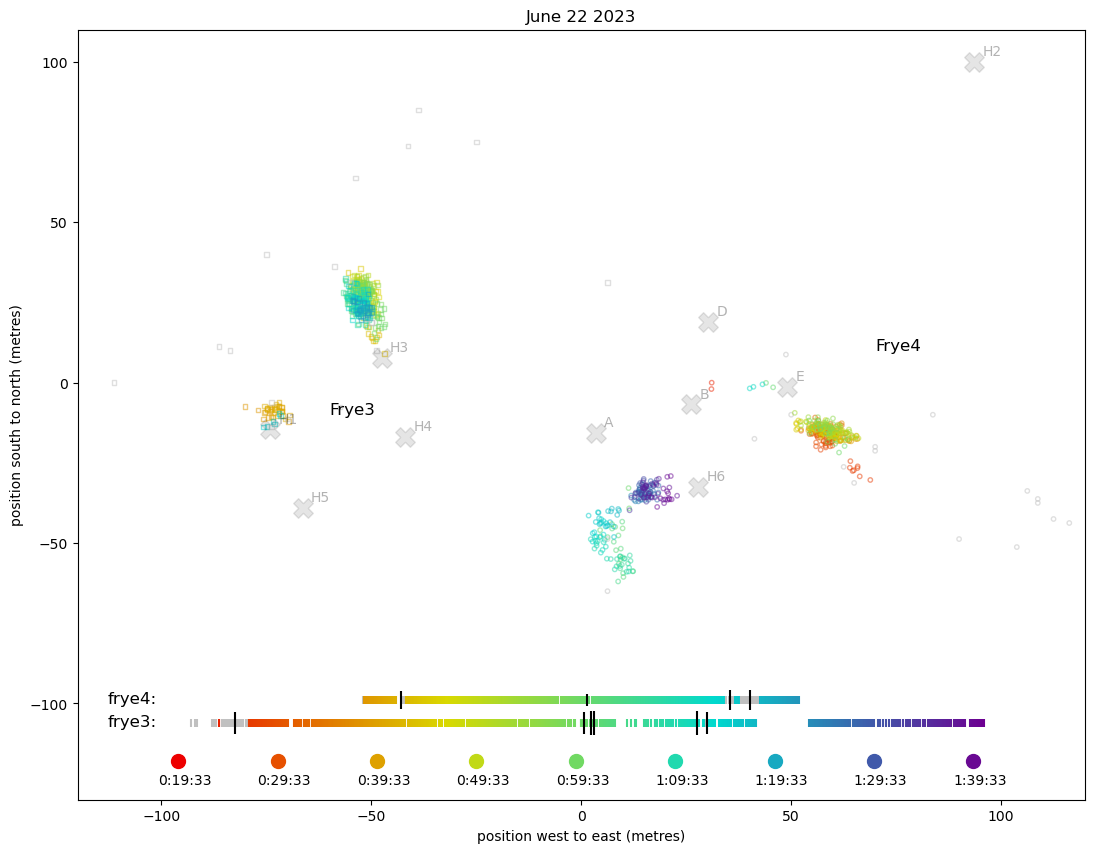

In [38]:
# displays final calculated locations of songs
def new_show_2d_timing_of_points(recorder_locations, bird_points, oglocs, song_times, birdIDs, x_low_border, x_upper_border, y_low_border, y_upper_border, title, jitter_max=0):
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)

    xs = []
    ys = []
    cs = []

    full_bout_end = song_times[-1]
    full_bout_start = song_times[0]
    full_bout_len = full_bout_end - full_bout_start
    
    color1 = "#ed0000"
    color2 = "#d9d900"
    color3 = "#00d9ce"
    color4 = "#6d0091"
    colors1 = get_color_gradient(color1, color2, int((full_bout_len)/3) + 1)
    colors2 = get_color_gradient(color2, color3, int((full_bout_len)/3) + 1)
    colors3 = get_color_gradient(color3, color4, int((full_bout_len)/3) + 1)
    colors = colors1 + colors2 + colors3
    print(len(colors))

    #create reference dots at bottom of graph
    intervals = create_min_intervals(song_times, 600)
    print(intervals)
    x_len = x_upper_border - x_low_border
    x_intervals = []
    x_begin = x_low_border + (x_len/10)
    for i, interval in enumerate(intervals):
        x_intervals.append(x_begin + (interval / len(colors)) * x_len * .8)
    print(x_intervals)
    y_val = y_low_border + (y_upper_border - y_low_border) * .05
    y_interval_text = y_low_border + (y_upper_border - y_low_border) * .02
    for i, dot in enumerate(intervals):
        ax.scatter(x_intervals[i], y_val, c=colors[intervals[i]], s=100)
        dot_time = round(intervals[i] + full_bout_start)
        time_str = str(timedelta(seconds=dot_time))
        ax.annotate(f"{time_str}", (x_intervals[i] - (x_len * .02), y_interval_text))

    markers = ['o', 's', 'd', '^']
    #place bird points
    print('avlocs length: ', len(avlocs))
    print('oglocs length: ', len(oglocs))
    print('bird points length: ', len(bird_points))
    for i, point in enumerate(bird_points):
        if np.any(np.isnan(point)):
            if np.any(np.isnan(oglocs[i])):
                continue
            else:
                x = oglocs[i][0]
                y = oglocs[i][1]
                c = 'silver'
        else:
            x = bird_points[i][0] + random.uniform(-jitter_max, jitter_max)
            y = bird_points[i][1] + random.uniform(-jitter_max, jitter_max)
            c = colors[int(song_times[i] - full_bout_start)]
        ID_index = list(unique_IDs).index(birdIDs[i])
        marker = markers[ID_index]
        if ID_index == 2:
            alpha = .5
        else:
            alpha = .5
        ax.scatter(x, y, s=10, alpha=alpha, marker=marker, facecolors='none', edgecolors=c)
        x_line = x_begin + (((song_times[i] - full_bout_start)/full_bout_len) * x_len * .8)
        y_line = y_low_border + (y_upper_border - y_low_border) * (.1 + (.03 * ID_index))
        ax.scatter(x_line, y_line, c=c if not np.any(np.isnan(avlocs[i])) else 'silver', s=30, marker='|')

    #add jumps and text
    for bird_i, ID in enumerate(unique_IDs):
        for i, jump in enumerate(all_bird_jumps[bird_i]):
            jump_x = x_begin + (((jump - full_bout_start)/full_bout_len) * x_len * .8)
            jump_y = y_low_border + (y_upper_border - y_low_border) * (.1 + .03 * bird_i)
            ax.scatter(jump_x, jump_y, c='black', s=all_bird_jump_dists[bird_i][i]*5, marker='|')

        ax.text(x_low_border + 3 * (x_len/100), y_low_border + (y_upper_border - y_low_border) * (.095 + .03 * bird_i), f"{ID}:", fontsize=12)


    ax.text(70, 10, "Frye4", fontsize=12)
    ax.text(-60, -10, "Frye3", fontsize=12)
    
    recorder_names = ['A', 'B', 'D', 'E', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']
    for i in range(len(recorder_locations)):
        ax.scatter(recorder_locations[i][0], recorder_locations[i][1], 200, marker='X', c='black', alpha=0.1)
        ax.annotate(f"{recorder_names[i]}", (recorder_locations[i][0]+2, recorder_locations[i][1]+2), alpha=0.3)
    ax.set_xlim(x_low_border, x_upper_border)
    ax.set_ylim(y_low_border,y_upper_border)

    plt.title(title)
    # plt.legend(loc='upper left')
    plt.xlabel('position west to east (metres)')
    plt.ylabel('position south to north (metres)')
    plt.savefig('jun23-2023.png')
    plt.show()
    plt.close()

start = 0
end = 100000
new_show_2d_timing_of_points(metric_coords, avlocs[start:end], oglocs[start:end], song_times[start:end], birdIDs[start:end], -120, 120, -130, 110, 'June 22 2023', jitter_max=2)